In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import List, Tuple, Optional, Any



GRID_ROWS: int = 50
GRID_COLUMNS: int = 50

NUM_PARTICLES_PERCENTAGE: float = 0.05 

SIMULATION_STEPS: int = 100

ANIMATION_INTERVAL_MS: int = 300  

BOUNDARY_TYPE: str = 'wall'  


ANIMATION_FILENAME: str = "fhp_simulation.gif" 

# ANIMATION_FILENAME: str = "fhp_simulation_v3_circular_particles_red.mp4"

# Set a seed for reproducible simulations. Set to None for random behavior.
RANDOM_SEED: Optional[int] = 42


class Node:
    
    """Represents a single cell in the lattice."""
    
    def __init__(self, is_wall: bool = False):
        self.ni_s: List[int] = [0] * 6
        self.is_wall: bool = is_wall
        self.occupied: int = 1 if is_wall else 0

    def __repr__(self) -> str:
        return f"Node(wall={self.is_wall}, ni_s={self.ni_s}, occupied={self.occupied})"


def initialize_lattice(rows: int, cols: int, boundary_type: str) -> np.ndarray:
    
    """Initializes the simulation lattice with Node objects."""
    lattice = np.array([[Node(is_wall=False) for _ in range(cols)] for _ in range(rows)], dtype=object)
    
    if boundary_type == 'wall':
        for r_idx in range(rows):
            for c_idx in range(cols):
                if r_idx == 0 or r_idx == rows - 1 or c_idx == 0 or c_idx == cols - 1:
                    lattice[r_idx, c_idx] = Node(is_wall=True)
    return lattice

# --- Neighbor Finding ---
def get_hexagonal_neighbors(coords: Tuple[int, int], rows: int, cols: int) -> List[Tuple[int, int]]:
    """Gets the 6 neighbors of a cell in a hexagonal layout on a square grid."""
    r, c = coords
    return [
        (r, (c + 1) % cols),
        ((r - 1 + rows) % rows, (c + 1) % cols),
        ((r - 1 + rows) % rows, (c - 1 + cols) % cols),
        (r, (c - 1 + cols) % cols),
        ((r + 1) % rows, (c - 1 + cols) % cols),
        ((r + 1) % rows, (c + 1) % cols)
    ]


# --- Particle Initialization ---
def fill_lattice_randomly(
    lattice: np.ndarray, 
    num_particles_percentage: float, 
    rows: int, 
    cols: int, 
    boundary_type: str
    ):
    """
    Fills the lattice randomly with particles across the entire grid.
    Particles occupy unique (cell_row, cell_col, direction_index) slots.
    The number of particles is determined by num_particles_percentage of available slots.
    """
    possible_slots: List[Tuple[int, int, int]] = []
    
    for r_idx in range(rows):
        for c_idx in range(cols):
            if boundary_type == 'wall' and lattice[r_idx, c_idx].is_wall:
                continue
            for direction_idx in range(6):
                possible_slots.append((r_idx, c_idx, direction_idx))
    
    if not possible_slots:
        print("Warning: No available slots to place particles.")
        return

    num_particles_to_place = int(num_particles_percentage * len(possible_slots))
    if num_particles_to_place == 0 and num_particles_percentage > 0 and possible_slots:
        num_particles_to_place = 1
        
    actual_num_particles = min(num_particles_to_place, len(possible_slots))

    if actual_num_particles > 0:
        chosen_slots = random.sample(possible_slots, actual_num_particles)
        for r_idx, c_idx, direction_idx in chosen_slots:
            lattice[r_idx, c_idx].ni_s[direction_idx] = 1
            lattice[r_idx, c_idx].occupied = 1
    
    print(f"Initialized {actual_num_particles} particles across the grid (out of {len(possible_slots)} available slots, {num_particles_percentage*100:.2f}% target density).")


# --- FHP-II Collision Rules ---
def _d_predicate(ni_s: List[int], k: int) -> int:
    
    if ni_s[k % 6] == 1 and \
       ni_s[(k + 3) % 6] == 1 and \
       ni_s[(k + 1) % 6] == 0 and \
       ni_s[(k + 2) % 6] == 0 and \
       ni_s[(k + 4) % 6] == 0 and \
       ni_s[(k + 5) % 6] == 0:
        return 1
    return 0



def _t_predicate(ni_s: List[int], k: int) -> int:
    if ni_s[k % 6] == 1 and \
       ni_s[(k + 2) % 6] == 1 and \
       ni_s[(k + 4) % 6] == 1 and \
       ni_s[(k + 1) % 6] == 0 and \
       ni_s[(k + 3) % 6] == 0 and \
       ni_s[(k + 5) % 6] == 0:
        return 1
    return 0


def calculate_collision_factor_omega(ni_s: List[int], i: int) -> int:
    q = random.choice([0, 1])
    loss_from_d_collision_on_i_axis = _d_predicate(ni_s, i)
    gain_from_d_collision_on_i_minus_1_axis = q * _d_predicate(ni_s, (i - 1 + 6) % 6)
    gain_from_d_collision_on_i_plus_1_axis = (1 - q) * _d_predicate(ni_s, (i + 1 + 6) % 6)
    loss_from_t_collision_involving_i = _t_predicate(ni_s, i)
    gain_from_t_collision_involving_i_plus_3 = _t_predicate(ni_s, (i + 3 + 6) % 6)
    omega = (
        -loss_from_d_collision_on_i_axis +
        gain_from_d_collision_on_i_minus_1_axis +
        gain_from_d_collision_on_i_plus_1_axis -
        loss_from_t_collision_involving_i +
        gain_from_t_collision_involving_i_plus_3
    )
    return int(omega)




# --- Simulation Step ---
def simulation_step(current_lattice: np.ndarray, rows: int, cols: int, boundary_type: str) -> np.ndarray:
    """Performs one step of the FHP simulation (collision and propagation)."""
    next_lattice = initialize_lattice(rows, cols, boundary_type)
    for r_idx in range(rows):
        for c_idx in range(cols):
            current_node = current_lattice[r_idx, c_idx]
            if boundary_type == 'wall' and current_node.is_wall:
                continue
            current_ni_s = current_node.ni_s
            ni_s_post_collision = [0] * 6
            for k_direction in range(6):
                omega_k = calculate_collision_factor_omega(current_ni_s, k_direction)
                particles_in_k_after_collision = current_ni_s[k_direction] + omega_k
                if particles_in_k_after_collision < 0: particles_in_k_after_collision = 0
                if particles_in_k_after_collision > 1: particles_in_k_after_collision = 1
                ni_s_post_collision[k_direction] = particles_in_k_after_collision
            
            neighbor_coords_list = get_hexagonal_neighbors((r_idx, c_idx), rows, cols)
            for k_direction in range(6):
                if ni_s_post_collision[k_direction] == 1:
                    dest_r, dest_c = neighbor_coords_list[k_direction]
                    if boundary_type == 'wall' and next_lattice[dest_r, dest_c].is_wall:
                        next_lattice[r_idx, c_idx].ni_s[(k_direction + 3) % 6] = 1
                    else:
                        next_lattice[dest_r, dest_c].ni_s[k_direction] = 1

    for r_idx in range(rows):
        for c_idx in range(cols):
            node_to_update = next_lattice[r_idx, c_idx]
            if not node_to_update.is_wall:
                if any(particle_present == 1 for particle_present in node_to_update.ni_s):
                    node_to_update.occupied = 1
                else:
                    node_to_update.occupied = 0
    return next_lattice

# --- Visualization and Animation ---
def get_particle_coordinates(lattice: np.ndarray, rows: int, cols: int) -> Tuple[List[int], List[int]]:
    """Extracts x (column) and y (row) coordinates of occupied cells (particles)."""
    x_coords: List[int] = []
    y_coords: List[int] = []
    for r_idx in range(rows):
        for c_idx in range(cols):
            if lattice[r_idx, c_idx].occupied == 1 and not lattice[r_idx, c_idx].is_wall:
                x_coords.append(c_idx) # x is column
                y_coords.append(r_idx) # y is row
    return x_coords, y_coords

def display_lattice_state(lattice: np.ndarray, rows: int, cols: int, step_num: int = -1):
    """Displays a single state of the lattice using Matplotlib scatter plot for circular particles."""
    x_coords, y_coords = get_particle_coordinates(lattice, rows, cols)
    
    plt.figure(figsize=(7, 6))
    ax = plt.gca() # Get current axes
    
    # Plot walls if any (simple imshow for walls)
    wall_grid = np.zeros((rows, cols), dtype=np.int8)
    for r_idx in range(rows):
        for c_idx in range(cols):
            if lattice[r_idx, c_idx].is_wall:
                 wall_grid[r_idx,c_idx] = 1
    # Use a light gray for walls, imshow renders from top-left
    ax.imshow(wall_grid, cmap='Greys', vmin=0, vmax=5, alpha=0.3, origin='upper', extent=[-0.5, cols-0.5, rows-0.5, -0.5])


    # Scatter plot for particles
    # Adjust marker size 's' as needed. It's in points^2.
    # A reasonable size depends on the grid density.
    marker_area = (0.8 * min(700/cols, 600/rows))**2 # Heuristic for marker size
    ax.scatter(x_coords, y_coords, s=marker_area, c='red', marker='o')
    
    ax.set_xlim(-0.5, cols - 0.5)
    # Invert y-axis to match imshow's typical origin (0,0 at top-left)
    ax.set_ylim(rows - 0.5, -0.5) 
    ax.set_aspect('equal', adjustable='box') # Ensure circles are circular

    title = "FHP Lattice State (Circular Particles)"
    if step_num >= 0:
        title += f" - Step {step_num}"
    ax.set_title(title)
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.tight_layout()
    plt.show()

def build_and_save_animation(
    lattice_states: List[np.ndarray], # List of full lattice states (Node objects)
    rows: int,
    cols: int,
    filename: str = "fhp_simulation.gif", 
    interval_ms: int = 150,
    particle_color: str = 'red'
    ):
    """Builds and saves an animation from a list of lattice states using scatter plot."""
    if not lattice_states:
        print("Error: No states provided for animation.")
        return

    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Initial empty scatter plot for particles
    # Marker size calculation (heuristic)
    marker_area = (0.8 * min(700/cols, 600/rows))**2 
    scatter_plot = ax.scatter([], [], s=marker_area, c=particle_color, marker='o')

    # Plot walls once as a background (if boundary_type is 'wall')
    # This assumes walls don't change during simulation.
    wall_grid = np.zeros((rows, cols), dtype=np.int8)
    # Check the first state for walls, assuming they are static.
    # This is a simplification; if walls could change, this would need to be in update_frame.
    if BOUNDARY_TYPE == 'wall': # Access global BOUNDARY_TYPE
        for r_idx in range(rows):
            for c_idx in range(cols):
                if lattice_states[0][r_idx, c_idx].is_wall: # Check the first state
                    wall_grid[r_idx,c_idx] = 1
    # imshow renders from top-left (0,0) by default unless origin is changed
    ax.imshow(wall_grid, cmap='Greys', vmin=0, vmax=5, alpha=0.3, origin='upper', extent=[-0.5, cols-0.5, rows-0.5, -0.5])


    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5) # Inverted y-axis
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"FHP Simulation - Step 0")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.tight_layout()

    def update_frame(frame_num: int):
        current_lattice = lattice_states[frame_num]
        x_coords, y_coords = get_particle_coordinates(current_lattice, rows, cols)
        
        # Update scatter plot data
        # np.c_ stacks 1D arrays as columns into a 2D array
        if x_coords: # Check if there are any particles to plot
            scatter_plot.set_offsets(np.c_[x_coords, y_coords])
        else: # No particles, set offsets to empty
            scatter_plot.set_offsets(np.empty((0, 2)))
            
        ax.set_title(f"FHP Simulation (Circular Particles) - Step {frame_num}")
        return [scatter_plot] # Return list of modified artists

    ani = animation.FuncAnimation(fig, update_frame, frames=len(lattice_states),
                                  interval=interval_ms, blit=True, repeat=False)
    try:
        print(f"Attempting to save animation as {filename}...")
        actual_fps = 1000.0 / interval_ms if interval_ms > 0 else 10.0 
        
        if filename.endswith(".mp4"):
            writer = animation.FFMpegWriter(fps=actual_fps, metadata=dict(artist='FHP-II Simulation'), bitrate=1800)
            ani.save(filename, writer=writer)
            print(f"Animation saved as {filename}. (Requires ffmpeg)")
        elif filename.endswith(".gif"):
            writer = animation.PillowWriter(fps=actual_fps)
            ani.save(filename, writer=writer)
            print(f"Animation saved as {filename}. (Requires Pillow)")
        else:
            print(f"Unsupported file extension: {filename}.")
            return
    except Exception as e:
        print(f"Error saving animation: {e}")
    finally:
        plt.close(fig)

# --- Main Execution ---
if __name__ == '__main__':
    if RANDOM_SEED is not None:
        print(f"Using random seed: {RANDOM_SEED}")
        random.seed(RANDOM_SEED)

    print(f"--- FHP-II Lattice Gas Simulation (Circular Particles) ---")
    print(f"Grid Dimensions: {GRID_ROWS}x{GRID_COLUMNS}")
    print(f"Particle Density Target: {NUM_PARTICLES_PERCENTAGE*100:.2f}% of total grid")
    # print(f"Initial Dot Radius Fraction: {INITIAL_DOT_RADIUS_FRACTION}") # No longer using dot
    print(f"Simulation Steps: {SIMULATION_STEPS}")
    print(f"Boundary Type: {BOUNDARY_TYPE}")
    print(f"Animation Output: {ANIMATION_FILENAME} (Interval: {ANIMATION_INTERVAL_MS}ms)")

    current_lattice_state = initialize_lattice(GRID_ROWS, GRID_COLUMNS, BOUNDARY_TYPE)
    
    # Populate with particles across the grid
    fill_lattice_randomly(
        current_lattice_state, 
        NUM_PARTICLES_PERCENTAGE, 
        GRID_ROWS, 
        GRID_COLUMNS, 
        BOUNDARY_TYPE
        # Removed dot_radius_fraction parameter
    )

    # Store full lattice states for animation using scatter plot
    lattice_history_for_animation: List[np.ndarray] = [current_lattice_state.copy()] 

    print("\nStarting simulation loop...")
    for step in range(SIMULATION_STEPS):
        current_lattice_state = simulation_step(current_lattice_state, GRID_ROWS, GRID_COLUMNS, BOUNDARY_TYPE)
        lattice_history_for_animation.append(current_lattice_state.copy()) # Store a copy of the full state
        
        if SIMULATION_STEPS == 0: break
        print_interval = max(1, SIMULATION_STEPS // 20)
        if (step + 1) % print_interval == 0 or (step + 1) == SIMULATION_STEPS:
            print(f"  Completed step {step + 1}/{SIMULATION_STEPS}")
    
    print("\nSimulation finished.")
    
    if lattice_history_for_animation:
        build_and_save_animation(
            lattice_history_for_animation, # Pass list of Node arrays
            GRID_ROWS,
            GRID_COLUMNS,
            filename=ANIMATION_FILENAME, 
            interval_ms=ANIMATION_INTERVAL_MS
        )
    else:
        print("No frames were generated for the animation.")

    print("\n--- Simulation Complete ---")


Using random seed: 42
--- FHP-II Lattice Gas Simulation (Circular Particles) ---
Grid Dimensions: 50x50
Particle Density Target: 5.00% of total grid
Simulation Steps: 100
Boundary Type: wall
Animation Output: fhp_simulation.gif (Interval: 300ms)
Initialized 691 particles across the grid (out of 13824 available slots, 5.00% target density).

Starting simulation loop...
  Completed step 5/100
  Completed step 10/100
  Completed step 15/100
  Completed step 20/100
  Completed step 25/100
  Completed step 30/100
  Completed step 35/100
  Completed step 40/100
  Completed step 45/100
  Completed step 50/100
  Completed step 55/100
  Completed step 60/100
  Completed step 65/100
  Completed step 70/100
  Completed step 75/100
  Completed step 80/100
  Completed step 85/100
  Completed step 90/100
  Completed step 95/100
  Completed step 100/100

Simulation finished.
Attempting to save animation as fhp_simulation.gif...
Animation saved as fhp_simulation.gif. (Requires Pillow)

--- Simulation 

In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import List, Tuple, Optional, Any
import math # Added back for sqrt

# --- Configuration Parameters ---
GRID_ROWS: int = 50
GRID_COLUMNS: int = 50
# Percentage of total (cell, direction) slots WITHIN THE INITIAL DOT to fill
NUM_PARTICLES_PERCENTAGE: float = 0.20 # Increased for a denser dot
# Fraction of min(GRID_ROWS, GRID_COLUMNS) for the initial dot radius
INITIAL_DOT_RADIUS_FRACTION: float = 0.25 

SIMULATION_STEPS: int = 100
ANIMATION_INTERVAL_MS: int = 150  # Slower movement
BOUNDARY_TYPE: str = 'wall'  # Options: 'wall' or 'periodic'

# Default to GIF to avoid common ffmpeg issues for users
ANIMATION_FILENAME: str = "fhp_simulation_v3_dot_circular_particles_red.gif" # Updated filename
# To save as MP4 (requires ffmpeg installed and in PATH):
# ANIMATION_FILENAME: str = "fhp_simulation_v3_dot_circular_particles_red.mp4"

# Set a seed for reproducible simulations. Set to None for random behavior.
RANDOM_SEED: Optional[int] = 42

# --- Node Class ---
class Node:
    """Represents a single cell in the lattice."""
    def __init__(self, is_wall: bool = False):
        self.ni_s: List[int] = [0] * 6
        self.is_wall: bool = is_wall
        # 'occupied' is primarily for visualization: 1 if wall or any particle present.
        self.occupied: int = 1 if is_wall else 0

    def __repr__(self) -> str:
        return f"Node(wall={self.is_wall}, ni_s={self.ni_s}, occupied={self.occupied})"

# --- Lattice Initialization ---
def initialize_lattice(rows: int, cols: int, boundary_type: str) -> np.ndarray:
    """Initializes the simulation lattice with Node objects."""
    lattice = np.array([[Node(is_wall=False) for _ in range(cols)] for _ in range(rows)], dtype=object)
    
    if boundary_type == 'wall':
        for r_idx in range(rows):
            for c_idx in range(cols):
                if r_idx == 0 or r_idx == rows - 1 or c_idx == 0 or c_idx == cols - 1:
                    lattice[r_idx, c_idx] = Node(is_wall=True)
    return lattice

# --- Neighbor Finding ---
def get_hexagonal_neighbors(coords: Tuple[int, int], rows: int, cols: int) -> List[Tuple[int, int]]:
    """Gets the 6 neighbors of a cell in a hexagonal layout on a square grid."""
    r, c = coords
    return [
        (r, (c + 1) % cols),
        ((r - 1 + rows) % rows, (c + 1) % cols),
        ((r - 1 + rows) % rows, (c - 1 + cols) % cols),
        (r, (c - 1 + cols) % cols),
        ((r + 1) % rows, (c - 1 + cols) % cols),
        ((r + 1) % rows, (c + 1) % cols)
    ]

# --- Particle Initialization ---
def fill_lattice_randomly(
    lattice: np.ndarray, 
    num_particles_percentage: float, 
    rows: int, 
    cols: int, 
    boundary_type: str,
    dot_radius_fraction: float # Added parameter for dot initialization
    ):
    """
    Fills the lattice with particles forming an initial round dot at the center.
    Particles occupy unique (cell_row, cell_col, direction_index) slots within the dot.
    The number of particles is determined by num_particles_percentage of available slots *within the dot*.
    """
    possible_slots: List[Tuple[int, int, int]] = []
    
    dot_center_r = rows // 2
    dot_center_c = cols // 2
    # Calculate radius based on the smaller dimension of the grid
    dot_radius = min(rows, cols) * dot_radius_fraction 
    
    print(f"Initializing particles in a dot at ({dot_center_r}, {dot_center_c}) with radius {dot_radius:.2f}.")

    for r_idx in range(rows):
        for c_idx in range(cols):
            # Skip wall cells if boundary_type is 'wall'
            if boundary_type == 'wall' and lattice[r_idx, c_idx].is_wall:
                continue
            
            # Check if the cell is within the dot radius
            distance_from_center = math.sqrt((r_idx - dot_center_r)**2 + (c_idx - dot_center_c)**2)
            
            if distance_from_center <= dot_radius:
                # For each cell within the dot, all 6 directions are potential slots
                for direction_idx in range(6):
                    possible_slots.append((r_idx, c_idx, direction_idx))
    
    if not possible_slots:
        print("Warning: No available slots within the defined dot to place particles (dot might be too small or outside non-wall area).")
        return

    num_particles_to_place = int(num_particles_percentage * len(possible_slots))
    # Ensure at least one particle if percentage > 0 and slots exist within the dot
    if num_particles_to_place == 0 and num_particles_percentage > 0 and possible_slots:
        num_particles_to_place = 1
        
    # Ensure we don't try to place more particles than available slots within the dot
    actual_num_particles = min(num_particles_to_place, len(possible_slots))

    if actual_num_particles > 0:
        chosen_slots = random.sample(possible_slots, actual_num_particles)
        for r_idx, c_idx, direction_idx in chosen_slots:
            lattice[r_idx, c_idx].ni_s[direction_idx] = 1
            lattice[r_idx, c_idx].occupied = 1 # Mark cell as occupied for visualization
    
    print(f"Initialized {actual_num_particles} particles within the dot (out of {len(possible_slots)} available slots in dot, {num_particles_percentage*100:.2f}% target density in dot).")


# --- FHP-II Collision Rules ---
def _d_predicate(ni_s: List[int], k: int) -> int:
    if ni_s[k % 6] == 1 and \
       ni_s[(k + 3) % 6] == 1 and \
       ni_s[(k + 1) % 6] == 0 and \
       ni_s[(k + 2) % 6] == 0 and \
       ni_s[(k + 4) % 6] == 0 and \
       ni_s[(k + 5) % 6] == 0:
        return 1
    return 0

def _t_predicate(ni_s: List[int], k: int) -> int:
    if ni_s[k % 6] == 1 and \
       ni_s[(k + 2) % 6] == 1 and \
       ni_s[(k + 4) % 6] == 1 and \
       ni_s[(k + 1) % 6] == 0 and \
       ni_s[(k + 3) % 6] == 0 and \
       ni_s[(k + 5) % 6] == 0:
        return 1
    return 0

def calculate_collision_factor_omega(ni_s: List[int], i: int) -> int:
    q = random.choice([0, 1])
    loss_from_d_collision_on_i_axis = _d_predicate(ni_s, i)
    gain_from_d_collision_on_i_minus_1_axis = q * _d_predicate(ni_s, (i - 1 + 6) % 6)
    gain_from_d_collision_on_i_plus_1_axis = (1 - q) * _d_predicate(ni_s, (i + 1 + 6) % 6)
    loss_from_t_collision_involving_i = _t_predicate(ni_s, i)
    gain_from_t_collision_involving_i_plus_3 = _t_predicate(ni_s, (i + 3 + 6) % 6)
    omega = (
        -loss_from_d_collision_on_i_axis +
        gain_from_d_collision_on_i_minus_1_axis +
        gain_from_d_collision_on_i_plus_1_axis -
        loss_from_t_collision_involving_i +
        gain_from_t_collision_involving_i_plus_3
    )
    return int(omega)

# --- Simulation Step ---
def simulation_step(current_lattice: np.ndarray, rows: int, cols: int, boundary_type: str) -> np.ndarray:
    next_lattice = initialize_lattice(rows, cols, boundary_type)

    for r_idx in range(rows):
        for c_idx in range(cols):
            current_node = current_lattice[r_idx, c_idx]

            if boundary_type == 'wall' and current_node.is_wall:
                continue 

            current_ni_s = current_node.ni_s
            ni_s_post_collision = [0] * 6

            for k_direction in range(6):
                omega_k = calculate_collision_factor_omega(current_ni_s, k_direction)
                particles_in_k_after_collision = current_ni_s[k_direction] + omega_k
                if particles_in_k_after_collision < 0: particles_in_k_after_collision = 0
                if particles_in_k_after_collision > 1: particles_in_k_after_collision = 1
                ni_s_post_collision[k_direction] = particles_in_k_after_collision
            
            neighbor_coords_list = get_hexagonal_neighbors((r_idx, c_idx), rows, cols)
            for k_direction in range(6):
                if ni_s_post_collision[k_direction] == 1: 
                    dest_r, dest_c = neighbor_coords_list[k_direction]
                    
                    if boundary_type == 'wall' and next_lattice[dest_r, dest_c].is_wall:
                        next_lattice[r_idx, c_idx].ni_s[(k_direction + 3) % 6] = 1
                    else:
                        next_lattice[dest_r, dest_c].ni_s[k_direction] = 1

    for r_idx in range(rows):
        for c_idx in range(cols):
            node_to_update = next_lattice[r_idx, c_idx]
            if any(particle_present == 1 for particle_present in node_to_update.ni_s):
                node_to_update.occupied = 1
            elif node_to_update.is_wall:
                node_to_update.occupied = 1 
            else:
                node_to_update.occupied = 0
            
    return next_lattice

# --- Visualization and Animation ---
def get_particle_coordinates(lattice: np.ndarray, rows: int, cols: int) -> Tuple[List[int], List[int]]:
    """Extracts x (column) and y (row) coordinates of cells containing particles."""
    x_coords: List[int] = []
    y_coords: List[int] = []
    for r_idx in range(rows):
        for c_idx in range(cols):
            if not lattice[r_idx, c_idx].is_wall and \
               any(p == 1 for p in lattice[r_idx, c_idx].ni_s): 
                x_coords.append(c_idx) 
                y_coords.append(r_idx) 
    return x_coords, y_coords

def display_lattice_state(lattice: np.ndarray, rows: int, cols: int, step_num: int = -1):
    """Displays a single state of the lattice using Matplotlib scatter plot for circular particles."""
    x_coords, y_coords = get_particle_coordinates(lattice, rows, cols)
    
    plt.figure(figsize=(7, 6))
    ax = plt.gca() 
    
    wall_grid = np.zeros((rows, cols), dtype=np.int8)
    for r_idx in range(rows):
        for c_idx in range(cols):
            if lattice[r_idx, c_idx].is_wall:
                 wall_grid[r_idx,c_idx] = 1
    ax.imshow(wall_grid, cmap='Greys', vmin=0, vmax=5, alpha=0.3, origin='upper', extent=[-0.5, cols-0.5, rows-0.5, -0.5])

    marker_area = (0.8 * min(700/cols, 600/rows))**2 
    ax.scatter(x_coords, y_coords, s=marker_area, c='red', marker='o', alpha=0.8)
    
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5) 
    ax.set_aspect('equal', adjustable='box') 

    title = "FHP Lattice State (Circular Particles)"
    if step_num >= 0:
        title += f" - Step {step_num}"
    ax.set_title(title)
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.tight_layout()
    plt.show()

def build_and_save_animation(
    lattice_states: List[np.ndarray], 
    rows: int,
    cols: int,
    filename: str = "fhp_simulation.gif", 
    interval_ms: int = 150,
    particle_color: str = 'red'
    ):
    """Builds and saves an animation from a list of lattice states using scatter plot."""
    if not lattice_states:
        print("Error: No states provided for animation.")
        return

    fig, ax = plt.subplots(figsize=(7, 6))
    
    marker_area = (0.8 * min(700/cols, 600/rows))**2 
    scatter_plot = ax.scatter([], [], s=marker_area, c=particle_color, marker='o', alpha=0.8)

    wall_grid_img = None
    if BOUNDARY_TYPE == 'wall': 
        wall_grid = np.zeros((rows, cols), dtype=np.int8)
        for r_idx in range(rows):
            for c_idx in range(cols):
                if lattice_states[0][r_idx, c_idx].is_wall: 
                    wall_grid[r_idx,c_idx] = 1
        wall_grid_img = ax.imshow(wall_grid, cmap='Greys', vmin=0, vmax=5, alpha=0.3, origin='upper', extent=[-0.5, cols-0.5, rows-0.5, -0.5])


    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5) 
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"FHP Simulation - Step 0")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.tight_layout()

    def update_frame(frame_num: int):
        current_lattice = lattice_states[frame_num]
        x_coords, y_coords = get_particle_coordinates(current_lattice, rows, cols)
        
        if x_coords: 
            scatter_plot.set_offsets(np.c_[x_coords, y_coords])
        else: 
            scatter_plot.set_offsets(np.empty((0, 2)))
            
        ax.set_title(f"FHP Simulation (Circular Particles) - Step {frame_num}")
        
        return [scatter_plot] 

    ani = animation.FuncAnimation(fig, update_frame, frames=len(lattice_states),
                                  interval=interval_ms, blit=True, repeat=False)
    try:
        print(f"Attempting to save animation as {filename}...")
        actual_fps = 1000.0 / interval_ms if interval_ms > 0 else 10.0 
        
        if filename.endswith(".mp4"):
            writer = animation.FFMpegWriter(fps=actual_fps, metadata=dict(artist='FHP-II Simulation'), bitrate=1800)
            ani.save(filename, writer=writer)
            print(f"Animation saved as {filename}. (Requires ffmpeg)")
        elif filename.endswith(".gif"):
            writer = animation.PillowWriter(fps=actual_fps)
            ani.save(filename, writer=writer)
            print(f"Animation saved as {filename}. (Requires Pillow)")
        else:
            print(f"Unsupported file extension: {filename}.")
            return
    except Exception as e:
        print(f"Error saving animation: {e}")
    finally:
        plt.close(fig)

# --- Main Execution ---
if __name__ == '__main__':
    if RANDOM_SEED is not None:
        print(f"Using random seed: {RANDOM_SEED}")
        random.seed(RANDOM_SEED)

    print(f"--- FHP-II Lattice Gas Simulation (Circular Particles - Dot Initial) ---") 
    print(f"Grid Dimensions: {GRID_ROWS}x{GRID_COLUMNS}")
    print(f"Particle Density Target (within dot): {NUM_PARTICLES_PERCENTAGE*100:.2f}%")
    print(f"Initial Dot Radius Fraction: {INITIAL_DOT_RADIUS_FRACTION}")
    print(f"Simulation Steps: {SIMULATION_STEPS}")
    print(f"Boundary Type: {BOUNDARY_TYPE}")
    print(f"Animation Output: {ANIMATION_FILENAME} (Interval: {ANIMATION_INTERVAL_MS}ms)")

    current_lattice_state = initialize_lattice(GRID_ROWS, GRID_COLUMNS, BOUNDARY_TYPE)
    
    # Populate with particles in a dot shape
    fill_lattice_randomly(
        current_lattice_state, 
        NUM_PARTICLES_PERCENTAGE, 
        GRID_ROWS, 
        GRID_COLUMNS, 
        BOUNDARY_TYPE,
        INITIAL_DOT_RADIUS_FRACTION # Pass the new parameter
    )

    lattice_history_for_animation: List[np.ndarray] = [current_lattice_state.copy()] 

    print("\nStarting simulation loop...")
    for step in range(SIMULATION_STEPS):
        current_lattice_state = simulation_step(current_lattice_state, GRID_ROWS, GRID_COLUMNS, BOUNDARY_TYPE)
        lattice_history_for_animation.append(current_lattice_state.copy()) 
        
        if SIMULATION_STEPS == 0: break
        print_interval = max(1, SIMULATION_STEPS // 20)
        if (step + 1) % print_interval == 0 or (step + 1) == SIMULATION_STEPS:
            print(f"  Completed step {step + 1}/{SIMULATION_STEPS}")
    
    print("\nSimulation finished.")
    
    if lattice_history_for_animation:
        build_and_save_animation(
            lattice_history_for_animation, 
            GRID_ROWS,
            GRID_COLUMNS,
            filename=ANIMATION_FILENAME, 
            interval_ms=ANIMATION_INTERVAL_MS
        )
    else:
        print("No frames were generated for the animation.")

    print("\n--- Simulation Complete ---")


Using random seed: 42
--- FHP-II Lattice Gas Simulation (Circular Particles - Dot Initial) ---
Grid Dimensions: 50x50
Particle Density Target (within dot): 20.00%
Initial Dot Radius Fraction: 0.25
Simulation Steps: 100
Boundary Type: wall
Animation Output: fhp_simulation_v3_dot_circular_particles_red.gif (Interval: 150ms)
Initializing particles in a dot at (25, 25) with radius 12.50.
Initialized 586 particles within the dot (out of 2934 available slots in dot, 20.00% target density in dot).

Starting simulation loop...
  Completed step 5/100
  Completed step 10/100
  Completed step 15/100
  Completed step 20/100
  Completed step 25/100
  Completed step 30/100
  Completed step 35/100
  Completed step 40/100
  Completed step 45/100
  Completed step 50/100
  Completed step 55/100
  Completed step 60/100
  Completed step 65/100
  Completed step 70/100
  Completed step 75/100
  Completed step 80/100
  Completed step 85/100
  Completed step 90/100
  Completed step 95/100
  Completed step 100

Initializing grid...
Grid initialized.
Starting simulation...
Simulated step: 10/200
Simulated step: 20/200
Simulated step: 30/200
Simulated step: 40/200
Simulated step: 50/200
Simulated step: 60/200
Simulated step: 70/200
Simulated step: 80/200
Simulated step: 90/200
Simulated step: 100/200
Simulated step: 110/200
Simulated step: 120/200
Simulated step: 130/200
Simulated step: 140/200
Simulated step: 150/200
Simulated step: 160/200
Simulated step: 170/200
Simulated step: 180/200
Simulated step: 190/200
Simulated step: 200/200
Simulation finished.
Creating animation object...
Animation object created.
Saving animation to covid_simulation.gif ... (This may take a while)
Animation successfully saved to covid_simulation.gif

--- Simulation Complete (200 steps) ---
Grid Size: 100x100
Final Empty Cells: 8348
Final Susceptible: 971 (58.78% of populated)
Final Exposed: 0 (0.00% of populated)
Final Infected: 2 (0.12% of populated)
Final Recovered: 679 (41.10% of populated)
Total Populated Cell

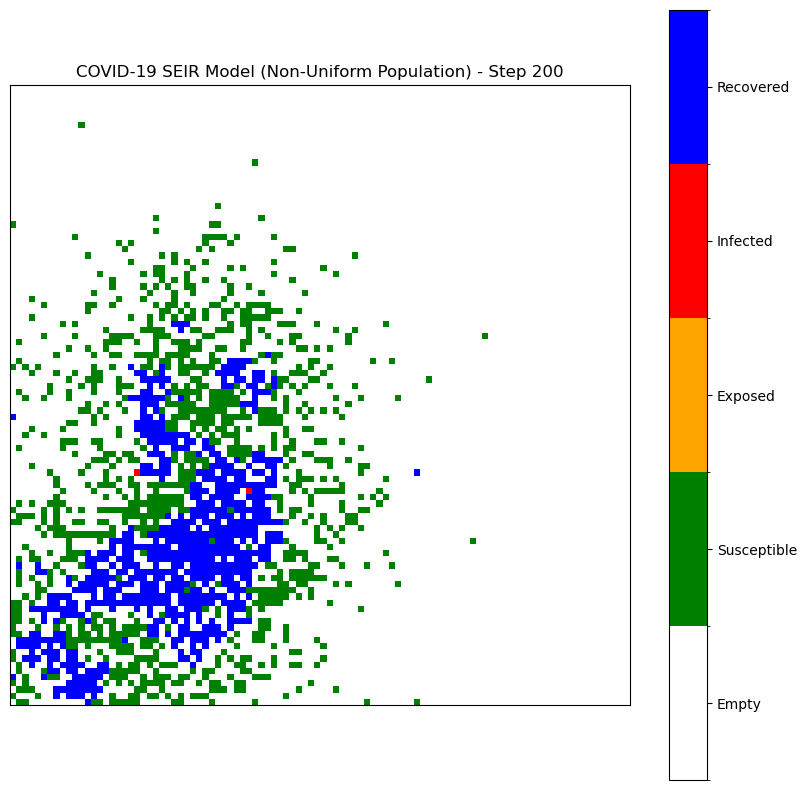

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
# Pillow is often used as a writer for GIFs with Matplotlib
# You might need to install it: pip install Pillow
# Alternatively, you might need other writers like imagemagick (more complex to set up)

# --- Simulation Parameters ---
GRID_SIZE = 100  # Size of the grid (GRID_SIZE x GRID_SIZE)
N_STEPS = 200   # Number of simulation steps

# --- COVID-19 Meta-Parameters (assuming 1 step = 1 day) ---
PROB_EXPOSED_BECOMES_INFECTED = 1/5
PROB_INFECTED_RECOVERS = 1/10
INFECTION_PROBABILITY = 0.075

# Population & Initial Conditions
TARGET_POPULATION_RATIO = 0.6
MAX_TOTAL_POPULATION = int((GRID_SIZE**2) * TARGET_POPULATION_RATIO * 0.7)
INITIAL_INFECTED_COUNT = 10
INITIAL_EXPOSED_COUNT = 20

N_POPULATION_CENTERS = 3
POPULATION_CENTER_STD_DEV_RANGE = (GRID_SIZE / 10, GRID_SIZE / 5)

# --- State Definitions ---
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# --- Color Mapping ---
colors = ['white', 'green', 'orange', 'red', 'blue']
cmap = mcolors.ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
tick_labels = ['Empty', 'Susceptible', 'Exposed', 'Infected', 'Recovered']

# --- Helper Functions ---
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-(((x - x0)**2 / (2 * sigma_x**2)) + ((y - y0)**2 / (2 * sigma_y**2))))

def initialize_grid_non_uniform(size, n_centers, std_dev_range, target_pop_max,
                                n_initial_infected, n_initial_exposed):
    grid = np.full((size, size), EMPTY, dtype=int)
    density_map = np.zeros((size, size))
    for _ in range(n_centers):
        x0 = np.random.randint(0, size)
        y0 = np.random.randint(0, size)
        sigma = np.random.uniform(std_dev_range[0], std_dev_range[1])
        for r in range(size):
            for c in range(size):
                density_map[r, c] += gaussian_2d(r, c, x0, y0, sigma, sigma)
    
    if np.max(density_map) > 0:
        density_map /= np.max(density_map)

    populated_count = 0
    susceptible_coords = []
    coords_with_density = []
    for r in range(size):
        for c in range(size):
            coords_with_density.append(((r, c), density_map[r, c]))
    coords_with_density.sort(key=lambda item: item[1], reverse=True)

    for (r, c), density_val in coords_with_density:
        if populated_count < target_pop_max:
            if np.random.rand() < density_val * TARGET_POPULATION_RATIO * 1.5:
                grid[r, c] = SUSCEPTIBLE
                susceptible_coords.append((r,c))
                populated_count += 1
        else:
            break
    
    if not susceptible_coords:
        print("Warning: No susceptible individuals placed.")
        return grid

    placed_exposed_infected_count = 0
    if susceptible_coords:
        indices_to_process = np.random.choice(len(susceptible_coords), 
                                              size=min(n_initial_exposed + n_initial_infected, len(susceptible_coords)), 
                                              replace=False)
        
        for i, sc_idx in enumerate(indices_to_process):
            r_s, c_s = susceptible_coords[sc_idx]
            if i < n_initial_exposed:
                grid[r_s, c_s] = EXPOSED
                placed_exposed_infected_count +=1
            elif i < n_initial_exposed + n_initial_infected:
                grid[r_s, c_s] = INFECTED
                placed_exposed_infected_count +=1
    
    if placed_exposed_infected_count < (n_initial_exposed + n_initial_infected):
         print(f"Warning: Could only place {placed_exposed_infected_count} of {n_initial_exposed + n_initial_infected} initial E/I individuals.")

    return grid

def count_infected_neighbors(grid, r, c):
    infected_neighbors = 0
    for i in range(max(0, r - 1), min(grid.shape[0], r + 2)):
        for j in range(max(0, c - 1), min(grid.shape[1], c + 2)):
            if (i, j) == (r, c):
                continue
            if grid[i, j] == INFECTED:
                infected_neighbors += 1
    return infected_neighbors

def update_grid(current_grid):
    new_grid = current_grid.copy()
    rows, cols = current_grid.shape
    for r in range(rows):
        for c in range(cols):
            state = current_grid[r, c]
            if state == EMPTY:
                continue
            elif state == SUSCEPTIBLE:
                infected_neighbors = count_infected_neighbors(current_grid, r, c)
                if infected_neighbors > 0:
                    prob_gets_infected = 1 - (1 - INFECTION_PROBABILITY) ** infected_neighbors
                    if np.random.rand() < prob_gets_infected:
                        new_grid[r, c] = EXPOSED
            elif state == EXPOSED:
                if np.random.rand() < PROB_EXPOSED_BECOMES_INFECTED:
                    new_grid[r, c] = INFECTED
            elif state == INFECTED:
                if np.random.rand() < PROB_INFECTED_RECOVERS:
                    new_grid[r, c] = RECOVERED
    return new_grid

# --- Main Simulation and Animation ---
grid_history = []
print("Initializing grid...")
current_grid = initialize_grid_non_uniform(GRID_SIZE, N_POPULATION_CENTERS, 
                                           POPULATION_CENTER_STD_DEV_RANGE,
                                           MAX_TOTAL_POPULATION,
                                           INITIAL_INFECTED_COUNT, INITIAL_EXPOSED_COUNT)
grid_history.append(current_grid.copy())
print("Grid initialized.")

# Run simulation
print("Starting simulation...")
for step in range(N_STEPS):
    current_grid = update_grid(current_grid)
    grid_history.append(current_grid.copy())
    if (step + 1) % 10 == 0 or step == N_STEPS -1: # Print progress
        print(f"Simulated step: {step+1}/{N_STEPS}")
print("Simulation finished.")

# Create animation
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(grid_history[0], cmap=cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-1, 0, 1, 2, 3], ax=ax)
cbar.ax.set_yticklabels(tick_labels)
ax.set_title(f"COVID-19 SEIR Model (Non-Uniform Population) - Step 0")
ax.set_xticks([])
ax.set_yticks([])

def animate(step):
    img.set_data(grid_history[step])
    ax.set_title(f"COVID-19 SEIR Model (Non-Uniform Population) - Step {step}")
    return [img]

print("Creating animation object...")
ani = FuncAnimation(fig, animate, frames=N_STEPS + 1, interval=150, blit=True, repeat=False)
print("Animation object created.")

# --- Save the animation as a GIF ---
gif_filename = 'covid_simulation.gif'
print(f"Saving animation to {gif_filename} ... (This may take a while)")
try:
    # Using Pillow writer is often a good choice for GIFs.
    # You might need to install Pillow: pip install Pillow
    ani.save(gif_filename, writer='pillow', fps=10) # Adjust fps as needed
    print(f"Animation successfully saved to {gif_filename}")
except Exception as e:
    print(f"Error saving GIF: {e}")
    print("Make sure you have a GIF writer installed, like Pillow (pip install Pillow).")
    print("Alternatively, you can try removing the writer='pillow' argument or try 'imagemagick' if installed.")

# plt.show() # You can uncomment this if you still want to see the plot window after saving

# --- Optional: Print final counts ---
final_grid = grid_history[-1]
empty_count = np.sum(final_grid == EMPTY)
susceptible_count = np.sum(final_grid == SUSCEPTIBLE)
exposed_count = np.sum(final_grid == EXPOSED)
infected_count = np.sum(final_grid == INFECTED)
recovered_count = np.sum(final_grid == RECOVERED)
total_populated = GRID_SIZE*GRID_SIZE - empty_count if GRID_SIZE*GRID_SIZE - empty_count > 0 else 1 # Avoid division by zero

print(f"\n--- Simulation Complete ({N_STEPS} steps) ---")
print(f"Grid Size: {GRID_SIZE}x{GRID_SIZE}")
print(f"Final Empty Cells: {empty_count}")
print(f"Final Susceptible: {susceptible_count} ({(susceptible_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Exposed: {exposed_count} ({(exposed_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Infected: {infected_count} ({(infected_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Recovered: {recovered_count} ({(recovered_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Total Populated Cells: {total_populated}")

Initializing grid...
Grid initialized.
Starting simulation...
Simulated step: 10/200
Simulated step: 20/200
Simulated step: 30/200
Simulated step: 40/200
Simulated step: 50/200
Simulated step: 60/200
Simulated step: 70/200
Simulated step: 80/200
Simulated step: 90/200
Simulated step: 100/200
Simulated step: 110/200
Simulated step: 120/200
Simulated step: 130/200
Simulated step: 140/200
Simulated step: 150/200
Simulated step: 160/200
Simulated step: 170/200
Simulated step: 180/200
Simulated step: 190/200
Simulated step: 200/200
Simulation finished.
Creating animation object...
Animation object created.
Saving animation to covid_simulation_larger_dots.gif ... (This may take a while due to upscaling)
Animation successfully saved to covid_simulation_larger_dots.gif

--- Simulation Complete (200 steps) ---
Simulation Grid Size: 70x70
Display Upscale Factor: 7
Final Empty Cells: 3359
Final Susceptible: 1205 (78.20% of populated)
Final Exposed: 3 (0.19% of populated)
Final Infected: 5 (0.32% 

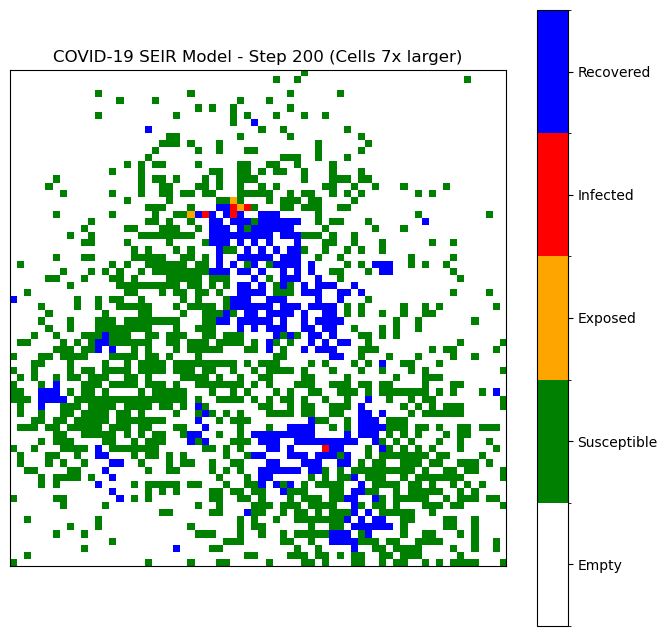

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
# Pillow is often used as a writer for GIFs with Matplotlib
# You might need to install it: pip install Pillow

# --- Simulation Parameters ---
GRID_SIZE = 70  # Size of the simulation grid (GRID_SIZE x GRID_SIZE)
                # Reducing grid size slightly to manage animation complexity with upscaling
UPSCALE_FACTOR = 7 # Each cell will be UPSCALE_FACTOR x UPSCALE_FACTOR pixels
N_STEPS = 200   # Number of simulation steps

# --- COVID-19 Meta-Parameters (assuming 1 step = 1 day) ---

# "TRANSMISSION POWER/INTENSITY" - Likelihood of infection per contact
# Base probability of an infected neighbor infecting a susceptible one per day.
# Higher values increase the "power" or "force" of infection.
INFECTION_PROBABILITY = 0.08  # Adjusted slightly for potentially sparser populations

# "TRANSMISSION SPEED" - Parameters affecting how quickly states progress
# --- Latency Period Control ---
# Probability of an exposed individual becoming infected per step (1 / average latency period)
# Higher value = Shorter latency period = Faster progression from Exposed to Infectious
# Average latency for COVID-19: ~5 days
PROB_EXPOSED_BECOMES_INFECTED = 1/5 # (0.2)

# --- Infectious Period Control ---
# Probability of an infected individual recovering per step (1 / average infection duration)
# Higher value = Shorter infectious period
# Average infectious period for COVID-19: ~10 days (can vary)
PROB_INFECTED_RECOVERS = 1/10 # (0.1)


# Population & Initial Conditions
TARGET_POPULATION_RATIO = 0.65 # Target ratio of populated cells in dense areas
MAX_TOTAL_POPULATION = int((GRID_SIZE**2) * TARGET_POPULATION_RATIO * 0.6) # Overall cap
INITIAL_INFECTED_COUNT = 8
INITIAL_EXPOSED_COUNT = 15

N_POPULATION_CENTERS = 3
POPULATION_CENTER_STD_DEV_RANGE = (GRID_SIZE / 8, GRID_SIZE / 4) # Adjusted for potentially smaller grid

# --- State Definitions ---
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# --- Color Mapping ---
colors = ['white', 'green', 'orange', 'red', 'blue']
cmap = mcolors.ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
tick_labels = ['Empty', 'Susceptible', 'Exposed', 'Infected', 'Recovered']

# --- Helper Functions ---
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-(((x - x0)**2 / (2 * sigma_x**2)) + ((y - y0)**2 / (2 * sigma_y**2))))

def initialize_grid_non_uniform(size, n_centers, std_dev_range, target_pop_max,
                                n_initial_infected, n_initial_exposed):
    grid = np.full((size, size), EMPTY, dtype=int)
    density_map = np.zeros((size, size))
    for _ in range(n_centers):
        x0 = np.random.randint(int(size*0.1), int(size*0.9)) # Bias centers away from extreme edges
        y0 = np.random.randint(int(size*0.1), int(size*0.9))
        sigma = np.random.uniform(std_dev_range[0], std_dev_range[1])
        for r in range(size):
            for c in range(size):
                density_map[r, c] += gaussian_2d(r, c, x0, y0, sigma, sigma)
    
    if np.max(density_map) > 0:
        density_map /= np.max(density_map)

    populated_count = 0
    susceptible_coords = []
    # Create a list of all possible coordinates and their densities
    all_coords = [(r, c) for r in range(size) for c in range(size)]
    # Shuffle to avoid bias from iteration order if densities are equal
    np.random.shuffle(all_coords)


    for r, c in all_coords:
        if populated_count < target_pop_max:
            # Populate based on density
            if np.random.rand() < density_map[r,c] * TARGET_POPULATION_RATIO * 1.2: # Heuristic
                grid[r, c] = SUSCEPTIBLE
                susceptible_coords.append((r,c))
                populated_count += 1
        else:
            break
    
    if not susceptible_coords:
        print("Warning: No susceptible individuals placed. Consider increasing MAX_TOTAL_POPULATION or TARGET_POPULATION_RATIO.")
        return grid

    placed_exposed_infected_count = 0
    if susceptible_coords:
        # Ensure we don't try to pick more individuals than available
        num_to_pick = min(n_initial_exposed + n_initial_infected, len(susceptible_coords))
        indices_to_process = np.random.choice(len(susceptible_coords), 
                                              size=num_to_pick, 
                                              replace=False)
        
        for i, sc_idx in enumerate(indices_to_process):
            r_s, c_s = susceptible_coords[sc_idx]
            if i < n_initial_exposed:
                grid[r_s, c_s] = EXPOSED
                placed_exposed_infected_count +=1
            # Check if there's still budget for infected after placing exposed
            elif placed_exposed_infected_count < (n_initial_exposed + n_initial_infected) and \
                 (i - n_initial_exposed) < n_initial_infected :
                grid[r_s, c_s] = INFECTED
                placed_exposed_infected_count +=1
    
    if placed_exposed_infected_count < (n_initial_exposed + n_initial_infected):
         print(f"Warning: Could only place {placed_exposed_infected_count} of {n_initial_exposed + n_initial_infected} initial E/I individuals.")

    return grid

def count_infected_neighbors(grid, r, c):
    infected_neighbors = 0
    for i in range(max(0, r - 1), min(grid.shape[0], r + 2)):
        for j in range(max(0, c - 1), min(grid.shape[1], c + 2)):
            if (i, j) == (r, c):
                continue
            if grid[i, j] == INFECTED:
                infected_neighbors += 1
    return infected_neighbors

def update_grid(current_grid):
    new_grid = current_grid.copy()
    rows, cols = current_grid.shape
    for r in range(rows):
        for c in range(cols):
            state = current_grid[r, c]
            if state == EMPTY:
                continue
            elif state == SUSCEPTIBLE:
                infected_neighbors = count_infected_neighbors(current_grid, r, c)
                if infected_neighbors > 0:
                    prob_gets_infected = 1 - (1 - INFECTION_PROBABILITY) ** infected_neighbors
                    if np.random.rand() < prob_gets_infected:
                        new_grid[r, c] = EXPOSED
            elif state == EXPOSED:
                if np.random.rand() < PROB_EXPOSED_BECOMES_INFECTED:
                    new_grid[r, c] = INFECTED
            elif state == INFECTED:
                if np.random.rand() < PROB_INFECTED_RECOVERS:
                    new_grid[r, c] = RECOVERED
    return new_grid

# --- Main Simulation and Animation ---
grid_history = []
print("Initializing grid...")
current_grid = initialize_grid_non_uniform(GRID_SIZE, N_POPULATION_CENTERS, 
                                           POPULATION_CENTER_STD_DEV_RANGE,
                                           MAX_TOTAL_POPULATION,
                                           INITIAL_INFECTED_COUNT, INITIAL_EXPOSED_COUNT)
grid_history.append(current_grid.copy())
print("Grid initialized.")

# Run simulation
print("Starting simulation...")
for step in range(N_STEPS):
    current_grid = update_grid(current_grid)
    grid_history.append(current_grid.copy())
    if (step + 1) % 10 == 0 or step == N_STEPS -1:
        print(f"Simulated step: {step+1}/{N_STEPS}")
print("Simulation finished.")

# Upscale grid for display
def upscale_grid_for_display(grid_small, factor):
    return np.kron(grid_small, np.ones((factor, factor), dtype=grid_small.dtype))

# Create animation
# Adjust figsize if needed based on upscaled grid visual size
fig_width_inches = 8 # Adjust as needed
fig_height_inches = 8 # Adjust as needed
fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

# Display the first upscaled frame
initial_display_grid = upscale_grid_for_display(grid_history[0], UPSCALE_FACTOR)
img = ax.imshow(initial_display_grid, cmap=cmap, norm=norm, interpolation='nearest')

cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-1, 0, 1, 2, 3], ax=ax)
cbar.ax.set_yticklabels(tick_labels)
ax.set_title(f"COVID-19 SEIR Model - Step 0 (Cells {UPSCALE_FACTOR}x larger)")
ax.set_xticks([])
ax.set_yticks([])

def animate(step):
    display_grid = upscale_grid_for_display(grid_history[step], UPSCALE_FACTOR)
    img.set_data(display_grid)
    ax.set_title(f"COVID-19 SEIR Model - Step {step} (Cells {UPSCALE_FACTOR}x larger)")
    return [img]

print("Creating animation object...")
ani = FuncAnimation(fig, animate, frames=N_STEPS + 1, interval=200, blit=True, repeat=False) # Interval can be adjusted
print("Animation object created.")

# --- Save the animation as a GIF ---
gif_filename = 'covid_simulation_larger_dots.gif'
print(f"Saving animation to {gif_filename} ... (This may take a while due to upscaling)")
try:
    ani.save(gif_filename, writer='pillow', fps=10) # Adjust fps as needed
    print(f"Animation successfully saved to {gif_filename}")
except Exception as e:
    print(f"Error saving GIF: {e}")
    print("Make sure you have a GIF writer installed, like Pillow (pip install Pillow).")

# --- Optional: Print final counts ---
final_grid = grid_history[-1] # Analysis on the original simulation grid
empty_count = np.sum(final_grid == EMPTY)
susceptible_count = np.sum(final_grid == SUSCEPTIBLE)
exposed_count = np.sum(final_grid == EXPOSED)
infected_count = np.sum(final_grid == INFECTED)
recovered_count = np.sum(final_grid == RECOVERED)
total_populated = GRID_SIZE*GRID_SIZE - empty_count if GRID_SIZE*GRID_SIZE - empty_count > 0 else 1

print(f"\n--- Simulation Complete ({N_STEPS} steps) ---")
print(f"Simulation Grid Size: {GRID_SIZE}x{GRID_SIZE}")
print(f"Display Upscale Factor: {UPSCALE_FACTOR}")
print(f"Final Empty Cells: {empty_count}")
print(f"Final Susceptible: {susceptible_count} ({(susceptible_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Exposed: {exposed_count} ({(exposed_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Infected: {infected_count} ({(infected_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Recovered: {recovered_count} ({(recovered_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Total Populated Cells: {total_populated}")

Initializing grid...
Grid initialized.
Starting simulation...
Simulated step: 10/200
Simulated step: 20/200
Simulated step: 30/200
Simulated step: 40/200
Simulated step: 50/200
Simulated step: 60/200
Simulated step: 70/200
Simulated step: 80/200
Simulated step: 90/200
Simulated step: 100/200
Simulated step: 110/200
Simulated step: 120/200
Simulated step: 130/200
Simulated step: 140/200
Simulated step: 150/200
Simulated step: 160/200
Simulated step: 170/200
Simulated step: 180/200
Simulated step: 190/200
Simulated step: 200/200
Simulation finished.
Creating animation object...
Animation object created.
Saving animation to covid_simulation_circular_dots_v2.gif ... (This may take a while)
Animation successfully saved to covid_simulation_circular_dots_v2.gif

--- Simulation Complete (200 steps) ---
Simulation Grid Size: 70x70
Marker Size (s parameter for scatter): 40
Final Empty Cells: 3626
Final Susceptible: 1002 (78.65% of populated)
Final Exposed: 6 (0.47% of populated)
Final Infected: 

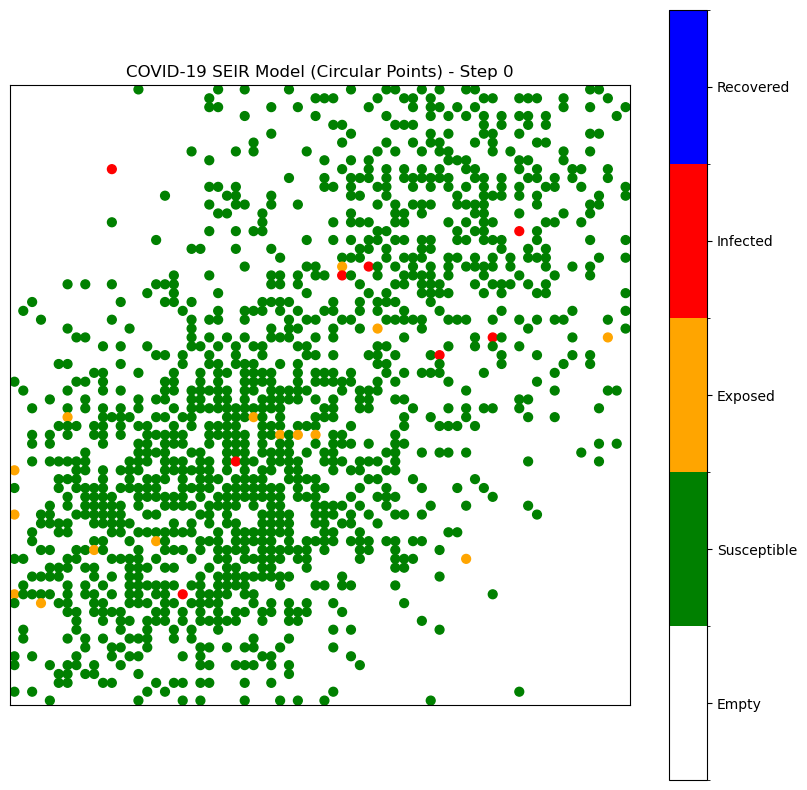

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
# Pillow is often used as a writer for GIFs with Matplotlib
# You might need to install it: pip install Pillow

# --- Simulation Parameters ---
GRID_SIZE = 70  # Size of the simulation grid (GRID_SIZE x GRID_SIZE)
N_STEPS = 200   # Number of simulation steps

# --- Visual Parameters ---
MARKER_SIZE = 40 # Try values like 20, 50, 100 etc. (Area of the marker in points^2)

# --- COVID-19 Meta-Parameters (assuming 1 step = 1 day) ---
INFECTION_PROBABILITY = 0.08 # "Transmission Power"
PROB_EXPOSED_BECOMES_INFECTED = 1/5 # Affects "Transmission Speed" (latency)
PROB_INFECTED_RECOVERS = 1/10    # Affects "Transmission Speed" (duration of illness)

# Population & Initial Conditions
TARGET_POPULATION_RATIO = 0.65
MAX_TOTAL_POPULATION = int((GRID_SIZE**2) * TARGET_POPULATION_RATIO * 0.6)
INITIAL_INFECTED_COUNT = 8
INITIAL_EXPOSED_COUNT = 15

N_POPULATION_CENTERS = 3
POPULATION_CENTER_STD_DEV_RANGE = (GRID_SIZE / 8, GRID_SIZE / 4)

# --- State Definitions ---
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# --- Color Mapping ---
colors_list = ['white', 'green', 'orange', 'red', 'blue'] # Order: EMPTY, S, E, I, R
cmap = mcolors.ListedColormap(colors_list)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5] # Boundaries for states EMPTY, S, E, I, R
norm = mcolors.BoundaryNorm(bounds, cmap.N)
tick_labels = ['Empty', 'Susceptible', 'Exposed', 'Infected', 'Recovered']


# --- Helper Functions ---
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    """Returns the value of a 2D Gaussian function."""
    return np.exp(-(((x - x0)**2 / (2 * sigma_x**2)) + ((y - y0)**2 / (2 * sigma_y**2))))

def initialize_grid_non_uniform(size, n_centers, std_dev_range, target_pop_max,
                                n_initial_infected, n_initial_exposed):
    """Initializes the grid with non-uniformly distributed population."""
    grid = np.full((size, size), EMPTY, dtype=int)
    density_map = np.zeros((size, size))
    
    for _ in range(n_centers):
        x0 = np.random.randint(int(size*0.1), int(size*0.9)) # Bias centers away from extreme edges
        y0 = np.random.randint(int(size*0.1), int(size*0.9))
        sigma = np.random.uniform(std_dev_range[0], std_dev_range[1])
        for r_idx in range(size):
            for c_idx in range(size):
                density_map[r_idx, c_idx] += gaussian_2d(r_idx, c_idx, x0, y0, sigma, sigma)
    
    if np.max(density_map) > 0:
        density_map /= np.max(density_map) # Normalize to 0-1

    populated_count = 0
    susceptible_coords = []
    # Create a list of all possible coordinates and shuffle to avoid bias
    all_coords = [(r_idx, c_idx) for r_idx in range(size) for c_idx in range(size)]
    np.random.shuffle(all_coords)

    for r_idx, c_idx in all_coords:
        if populated_count < target_pop_max:
            # Populate based on density
            if np.random.rand() < density_map[r_idx,c_idx] * TARGET_POPULATION_RATIO * 1.2: # Heuristic
                grid[r_idx, c_idx] = SUSCEPTIBLE
                susceptible_coords.append((r_idx,c_idx))
                populated_count += 1
        else:
            break
    
    if not susceptible_coords: # If no susceptible individuals were placed
        print("Warning: No susceptible individuals placed. Consider increasing MAX_TOTAL_POPULATION or TARGET_POPULATION_RATIO.")
        # Grid is already EMPTY, so this is fine for simulation logic
    
    # Place initially infected and exposed individuals (modifies the grid directly)
    placed_exposed_infected_count = 0
    if susceptible_coords: # Only proceed if there are susceptible individuals to convert
        # Ensure we don't try to pick more individuals than available
        num_to_pick = min(n_initial_exposed + n_initial_infected, len(susceptible_coords))
        
        # Get unique indices from susceptible_coords list
        indices_to_process = np.random.choice(len(susceptible_coords), 
                                              size=num_to_pick, 
                                              replace=False) # No replacement ensures unique individuals
        
        for i, sc_idx_in_list in enumerate(indices_to_process):
            r_s, c_s = susceptible_coords[sc_idx_in_list] # Get coords from the list
            
            if i < n_initial_exposed:
                grid[r_s, c_s] = EXPOSED
                placed_exposed_infected_count +=1
            # Check if there's still budget for infected after placing exposed
            # and ensure we don't exceed n_initial_infected
            elif (i - n_initial_exposed) < n_initial_infected : 
                grid[r_s, c_s] = INFECTED
                placed_exposed_infected_count +=1
            # This condition ensures we don't try to place more infected than requested
            # if num_to_pick was limited by len(susceptible_coords) for exposed.
    
    if placed_exposed_infected_count < (n_initial_exposed + n_initial_infected) and susceptible_coords:
         print(f"Warning: Could only place {placed_exposed_infected_count} of {n_initial_exposed + n_initial_infected} initial E/I individuals. (Susceptible count: {len(susceptible_coords)})")

    return grid


def count_infected_neighbors(grid, r, c):
    """Counts infected neighbors in a Moore neighborhood, ignoring EMPTY cells."""
    infected_neighbors = 0
    for i in range(max(0, r - 1), min(grid.shape[0], r + 2)):
        for j in range(max(0, c - 1), min(grid.shape[1], c + 2)):
            if (i, j) == (r, c): # Skip the cell itself
                continue
            if grid[i, j] == INFECTED: # Only INFECTED cells can spread
                infected_neighbors += 1
    return infected_neighbors

def update_grid(current_grid):
    """Updates the grid for one time step based on SEIR rules, handling EMPTY cells."""
    new_grid = current_grid.copy()
    rows, cols = current_grid.shape

    for r_idx in range(rows):
        for c_idx in range(cols):
            state = current_grid[r_idx, c_idx]

            if state == EMPTY: # Empty cells remain empty
                continue

            elif state == SUSCEPTIBLE:
                infected_neighbors = count_infected_neighbors(current_grid, r_idx, c_idx)
                if infected_neighbors > 0:
                    prob_gets_infected = 1 - (1 - INFECTION_PROBABILITY) ** infected_neighbors
                    if np.random.rand() < prob_gets_infected:
                        new_grid[r_idx, c_idx] = EXPOSED

            elif state == EXPOSED:
                if np.random.rand() < PROB_EXPOSED_BECOMES_INFECTED:
                    new_grid[r_idx, c_idx] = INFECTED

            elif state == INFECTED:
                if np.random.rand() < PROB_INFECTED_RECOVERS:
                    new_grid[r_idx, c_idx] = RECOVERED
            
            # RECOVERED state remains RECOVERED

    return new_grid

# --- Main Simulation and Animation ---
grid_history = []
print("Initializing grid...")
current_grid = initialize_grid_non_uniform(
    GRID_SIZE, N_POPULATION_CENTERS, POPULATION_CENTER_STD_DEV_RANGE,
    MAX_TOTAL_POPULATION, INITIAL_INFECTED_COUNT, INITIAL_EXPOSED_COUNT
)
grid_history.append(current_grid.copy())
print("Grid initialized.")

# Run simulation
print("Starting simulation...")
for step in range(N_STEPS):
    current_grid = update_grid(current_grid)
    grid_history.append(current_grid.copy())
    if (step + 1) % 10 == 0 or step == N_STEPS -1:
        print(f"Simulated step: {step+1}/{N_STEPS}")
print("Simulation finished.")


# Create animation using scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

# Prepare data for the first frame for scatter plot initialization
initial_particle_coords_xy_list = []
initial_particle_states_list = []
first_grid_frame = grid_history[0]
for r_idx in range(GRID_SIZE):
    for c_idx in range(GRID_SIZE):
        if first_grid_frame[r_idx, c_idx] != EMPTY:
            initial_particle_coords_xy_list.append([c_idx, r_idx]) # x=col, y=row
            initial_particle_states_list.append(first_grid_frame[r_idx, c_idx])

# Convert to numpy arrays for scatter
if not initial_particle_coords_xy_list: # Handle case of no particles in the first frame
    initial_coords_np = np.empty((0, 2))
    initial_states_np = np.array([])
else:
    initial_coords_np = np.array(initial_particle_coords_xy_list)
    initial_states_np = np.array(initial_particle_states_list)

scatter = ax.scatter(
    initial_coords_np[:, 0] if initial_coords_np.shape[0] > 0 else [], # x coordinates
    initial_coords_np[:, 1] if initial_coords_np.shape[0] > 0 else [], # y coordinates
    s=MARKER_SIZE, 
    c=initial_states_np if initial_states_np.size > 0 else [], # Ensure c is not empty if coords are empty
    cmap=cmap, 
    norm=norm,
    marker='o' 
)

ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(-0.5, GRID_SIZE - 0.5)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis() # To match imshow's typical (0,0) at top-left

# Create a mappable object for the colorbar if scatter.get_array() is empty initially
# This ensures colorbar shows all possible colors.
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([-1, 0, 1, 2, 3]) # Provide sample data for all states
cbar = plt.colorbar(mappable, boundaries=bounds, ticks=[-1, 0, 1, 2, 3], ax=ax)
cbar.ax.set_yticklabels(tick_labels)

ax.set_title(f"COVID-19 SEIR Model (Circular Points) - Step 0")
ax.set_xticks([])
ax.set_yticks([])


def animate(step):
    current_display_grid = grid_history[step]
    particle_coords_list = []
    particle_states_list = []
    for r_idx in range(GRID_SIZE):
        for c_idx in range(GRID_SIZE):
            if current_display_grid[r_idx, c_idx] != EMPTY:
                particle_coords_list.append([c_idx, r_idx]) # x is column, y is row
                particle_states_list.append(current_display_grid[r_idx, c_idx])
    
    if not particle_coords_list: # Handle empty frame if all are EMPTY
        scatter.set_offsets(np.empty((0,2)))
        # Setting an empty array for colors if offsets are empty
        # scatter.set_array(np.array([])) # This line might not be strictly needed if set_offsets clears data
    else:
        offsets_np = np.array(particle_coords_list)
        states_np = np.array(particle_states_list)
        scatter.set_offsets(offsets_np)
        scatter.set_array(states_np) # Update colors based on current states
        
    ax.set_title(f"COVID-19 SEIR Model (Circular Points) - Step {step}")
    # When blit=False, the function doesn't strictly need to return artists,
    # but it's good practice if you ever switch blit=True.
    return [scatter] # Returning the modified artist

print("Creating animation object...")
ani = FuncAnimation(fig, animate, frames=N_STEPS + 1, interval=200, blit=False, repeat=False)
print("Animation object created.")

# --- Save the animation as a GIF ---
gif_filename = 'covid_simulation_circular_dots_v2.gif'
print(f"Saving animation to {gif_filename} ... (This may take a while)")
try:
    # Pillow is a good writer for GIFs. Ensure it's installed: pip install Pillow
    ani.save(gif_filename, writer='pillow', fps=10) # Adjust fps as needed
    print(f"Animation successfully saved to {gif_filename}")
except Exception as e: # Corrected syntax from "except Exception e:"
    print(f"Error saving GIF: {e}")
    print("Make sure you have a GIF writer installed, like Pillow (pip install Pillow).")
    print("You might also need ffmpeg for other writers or formats if not using Pillow for GIF.")

# --- Optional: Print final counts ---
final_grid = grid_history[-1]
empty_count = np.sum(final_grid == EMPTY)
susceptible_count = np.sum(final_grid == SUSCEPTIBLE)
exposed_count = np.sum(final_grid == EXPOSED)
infected_count = np.sum(final_grid == INFECTED)
recovered_count = np.sum(final_grid == RECOVERED)
# Avoid division by zero if total_populated is 0
total_populated = (GRID_SIZE*GRID_SIZE - empty_count)
if total_populated == 0:
    print("Warning: Total populated count is zero. Percentages will be zero.")
    total_populated = 1 # To prevent division by zero in prints, effectively showing 0%

print(f"\n--- Simulation Complete ({N_STEPS} steps) ---")
print(f"Simulation Grid Size: {GRID_SIZE}x{GRID_SIZE}")
print(f"Marker Size (s parameter for scatter): {MARKER_SIZE}")
print(f"Final Empty Cells: {empty_count}")
print(f"Final Susceptible: {susceptible_count} ({(susceptible_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Exposed: {exposed_count} ({(exposed_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Infected: {infected_count} ({(infected_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Recovered: {recovered_count} ({(recovered_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Total Populated Cells at end: {GRID_SIZE*GRID_SIZE - empty_count}")

Initializing grid...
Grid initialized.
Starting simulation...
Simulated step: 10/200
Simulated step: 20/200
Simulated step: 30/200
Simulated step: 40/200
Simulated step: 50/200
Simulated step: 60/200
Simulated step: 70/200
Simulated step: 80/200
Simulated step: 90/200
Simulated step: 100/200
Simulated step: 110/200
Simulated step: 120/200
Simulated step: 130/200
Simulated step: 140/200
Simulated step: 150/200
Simulated step: 160/200
Simulated step: 170/200
Simulated step: 180/200
Simulated step: 190/200
Simulated step: 200/200
Simulation finished.
Creating animation object...
Animation object created.
Saving animation to covid_simulation_circular_dots_layout_v3.gif ... (This may take a while)
Animation successfully saved to covid_simulation_circular_dots_layout_v3.gif

--- Simulation Complete (200 steps) ---
Simulation Grid Size: 70x70
Marker Size (s parameter for scatter): 40
Final Empty Cells: 3341
Final Susceptible: 1030 (66.07% of populated)
Final Exposed: 0 (0.00% of populated)
Fi

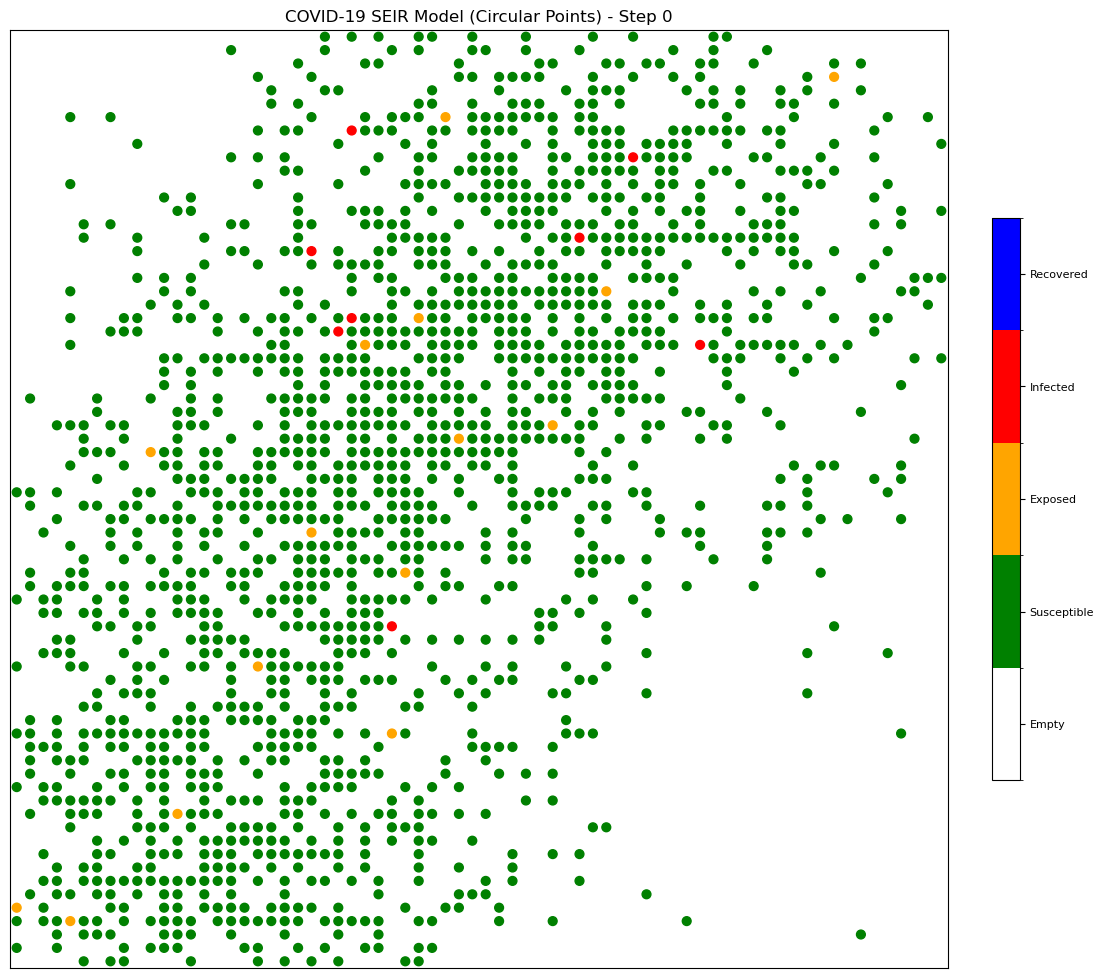

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
# Pillow is often used as a writer for GIFs with Matplotlib
# You might need to install it: pip install Pillow

# --- Simulation Parameters ---
GRID_SIZE = 70
N_STEPS = 200

# --- Visual Parameters ---
MARKER_SIZE = 40
# New parameters for figure and colorbar size
FIGURE_SIZE_INCHES = (12, 10) # Width, Height. Increased width for chart, height accommodates colorbar
COLORBAR_SHRINK_FACTOR = 0.6 # How much to shrink the colorbar (e.g., 0.6 = 60% of original height)
COLORBAR_FRACTION = 0.03 # Fraction of original axes to use for colorbar (adjust with shrink)
COLORBAR_PAD = 0.04       # Padding between chart and colorbar
COLORBAR_LABEL_FONTSIZE = 8 # Fontsize for tick labels on colorbar

# --- COVID-19 Meta-Parameters ---
INFECTION_PROBABILITY = 0.08
PROB_EXPOSED_BECOMES_INFECTED = 1/5
PROB_INFECTED_RECOVERS = 1/10

# Population & Initial Conditions
TARGET_POPULATION_RATIO = 0.65
MAX_TOTAL_POPULATION = int((GRID_SIZE**2) * TARGET_POPULATION_RATIO * 0.6)
INITIAL_INFECTED_COUNT = 8
INITIAL_EXPOSED_COUNT = 15

N_POPULATION_CENTERS = 3
POPULATION_CENTER_STD_DEV_RANGE = (GRID_SIZE / 8, GRID_SIZE / 4)

# --- State Definitions ---
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# --- Color Mapping ---
colors_list = ['white', 'green', 'orange', 'red', 'blue']
cmap = mcolors.ListedColormap(colors_list)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
tick_labels = ['Empty', 'Susceptible', 'Exposed', 'Infected', 'Recovered']

# --- Helper Functions --- (Remain unchanged from previous version)
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-(((x - x0)**2 / (2 * sigma_x**2)) + ((y - y0)**2 / (2 * sigma_y**2))))

def initialize_grid_non_uniform(size, n_centers, std_dev_range, target_pop_max,
                                n_initial_infected, n_initial_exposed):
    grid = np.full((size, size), EMPTY, dtype=int)
    density_map = np.zeros((size, size))
    for _ in range(n_centers):
        x0 = np.random.randint(int(size*0.1), int(size*0.9))
        y0 = np.random.randint(int(size*0.1), int(size*0.9))
        sigma = np.random.uniform(std_dev_range[0], std_dev_range[1])
        for r_idx in range(size):
            for c_idx in range(size):
                density_map[r_idx, c_idx] += gaussian_2d(r_idx, c_idx, x0, y0, sigma, sigma)
    if np.max(density_map) > 0:
        density_map /= np.max(density_map)
    populated_count = 0
    susceptible_coords = []
    all_coords = [(r_idx, c_idx) for r_idx in range(size) for c_idx in range(size)]
    np.random.shuffle(all_coords)
    for r_idx, c_idx in all_coords:
        if populated_count < target_pop_max:
            if np.random.rand() < density_map[r_idx,c_idx] * TARGET_POPULATION_RATIO * 1.2:
                grid[r_idx, c_idx] = SUSCEPTIBLE
                susceptible_coords.append((r_idx,c_idx))
                populated_count += 1
        else:
            break
    if not susceptible_coords:
        print("Warning: No susceptible individuals placed.")
    placed_exposed_infected_count = 0
    if susceptible_coords:
        num_to_pick = min(n_initial_exposed + n_initial_infected, len(susceptible_coords))
        indices_to_process = np.random.choice(len(susceptible_coords), size=num_to_pick, replace=False)
        for i, sc_idx_in_list in enumerate(indices_to_process):
            r_s, c_s = susceptible_coords[sc_idx_in_list]
            if i < n_initial_exposed:
                grid[r_s, c_s] = EXPOSED
                placed_exposed_infected_count +=1
            elif (i - n_initial_exposed) < n_initial_infected :
                grid[r_s, c_s] = INFECTED
                placed_exposed_infected_count +=1
    if placed_exposed_infected_count < (n_initial_exposed + n_initial_infected) and susceptible_coords:
         print(f"Warning: Could only place {placed_exposed_infected_count} of {n_initial_exposed + n_initial_infected} initial E/I individuals. (Susceptible count: {len(susceptible_coords)})")
    return grid

def count_infected_neighbors(grid, r, c):
    infected_neighbors = 0
    for i in range(max(0, r - 1), min(grid.shape[0], r + 2)):
        for j in range(max(0, c - 1), min(grid.shape[1], c + 2)):
            if (i, j) == (r, c): continue
            if grid[i, j] == INFECTED: infected_neighbors += 1
    return infected_neighbors

def update_grid(current_grid):
    new_grid = current_grid.copy()
    rows, cols = current_grid.shape
    for r_idx in range(rows):
        for c_idx in range(cols):
            state = current_grid[r_idx, c_idx]
            if state == EMPTY: continue
            elif state == SUSCEPTIBLE:
                infected_neighbors = count_infected_neighbors(current_grid, r_idx, c_idx)
                if infected_neighbors > 0:
                    prob_gets_infected = 1 - (1 - INFECTION_PROBABILITY) ** infected_neighbors
                    if np.random.rand() < prob_gets_infected: new_grid[r_idx, c_idx] = EXPOSED
            elif state == EXPOSED:
                if np.random.rand() < PROB_EXPOSED_BECOMES_INFECTED: new_grid[r_idx, c_idx] = INFECTED
            elif state == INFECTED:
                if np.random.rand() < PROB_INFECTED_RECOVERS: new_grid[r_idx, c_idx] = RECOVERED
    return new_grid

# --- Main Simulation and Animation ---
grid_history = []
print("Initializing grid...")
current_grid = initialize_grid_non_uniform(
    GRID_SIZE, N_POPULATION_CENTERS, POPULATION_CENTER_STD_DEV_RANGE,
    MAX_TOTAL_POPULATION, INITIAL_INFECTED_COUNT, INITIAL_EXPOSED_COUNT
)
grid_history.append(current_grid.copy())
print("Grid initialized.")

print("Starting simulation...")
for step in range(N_STEPS):
    current_grid = update_grid(current_grid)
    grid_history.append(current_grid.copy())
    if (step + 1) % 10 == 0 or step == N_STEPS -1:
        print(f"Simulated step: {step+1}/{N_STEPS}")
print("Simulation finished.")

# Create animation using scatter plot
fig, ax = plt.subplots(figsize=FIGURE_SIZE_INCHES) # Use new figure size

initial_particle_coords_xy_list = []
initial_particle_states_list = []
first_grid_frame = grid_history[0]
for r_idx in range(GRID_SIZE):
    for c_idx in range(GRID_SIZE):
        if first_grid_frame[r_idx, c_idx] != EMPTY:
            initial_particle_coords_xy_list.append([c_idx, r_idx])
            initial_particle_states_list.append(first_grid_frame[r_idx, c_idx])

if not initial_particle_coords_xy_list:
    initial_coords_np = np.empty((0, 2))
    initial_states_np = np.array([])
else:
    initial_coords_np = np.array(initial_particle_coords_xy_list)
    initial_states_np = np.array(initial_particle_states_list)

scatter = ax.scatter(
    initial_coords_np[:, 0] if initial_coords_np.shape[0] > 0 else [],
    initial_coords_np[:, 1] if initial_coords_np.shape[0] > 0 else [],
    s=MARKER_SIZE, 
    c=initial_states_np if initial_states_np.size > 0 else [],
    cmap=cmap, norm=norm, marker='o' 
)

ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(-0.5, GRID_SIZE - 0.5)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([-1, 0, 1, 2, 3])
# Modified colorbar call
cbar = plt.colorbar(mappable, boundaries=bounds, ticks=[-1, 0, 1, 2, 3], ax=ax,
                    shrink=COLORBAR_SHRINK_FACTOR, 
                    fraction=COLORBAR_FRACTION, 
                    pad=COLORBAR_PAD)
cbar.ax.set_yticklabels(tick_labels)
cbar.ax.tick_params(labelsize=COLORBAR_LABEL_FONTSIZE) # Set colorbar tick label size

ax.set_title(f"COVID-19 SEIR Model (Circular Points) - Step 0")
ax.set_xticks([])
ax.set_yticks([])


def animate(step):
    current_display_grid = grid_history[step]
    particle_coords_list = []
    particle_states_list = []
    for r_idx in range(GRID_SIZE):
        for c_idx in range(GRID_SIZE):
            if current_display_grid[r_idx, c_idx] != EMPTY:
                particle_coords_list.append([c_idx, r_idx])
                particle_states_list.append(current_display_grid[r_idx, c_idx])
    if not particle_coords_list:
        scatter.set_offsets(np.empty((0,2)))
    else:
        offsets_np = np.array(particle_coords_list)
        states_np = np.array(particle_states_list)
        scatter.set_offsets(offsets_np)
        scatter.set_array(states_np)
    ax.set_title(f"COVID-19 SEIR Model (Circular Points) - Step {step}")
    return [scatter]

print("Creating animation object...")
ani = FuncAnimation(fig, animate, frames=N_STEPS + 1, interval=200, blit=False, repeat=False)
print("Animation object created.")

# Apply tight_layout after all plot elements are added and before saving
# This helps fit everything nicely, especially with a modified colorbar
plt.tight_layout(pad=1.5) # Added some padding for tight_layout

gif_filename = 'covid_simulation_circular_dots_layout_v3.gif' # New filename
print(f"Saving animation to {gif_filename} ... (This may take a while)")
try:
    ani.save(gif_filename, writer='pillow', fps=10)
    print(f"Animation successfully saved to {gif_filename}")
except Exception as e:
    print(f"Error saving GIF: {e}")
    print("Make sure you have a GIF writer installed, like Pillow (pip install Pillow).")

# --- Final Counts --- (Remain unchanged)
final_grid = grid_history[-1]
empty_count = np.sum(final_grid == EMPTY)
susceptible_count = np.sum(final_grid == SUSCEPTIBLE)
exposed_count = np.sum(final_grid == EXPOSED)
infected_count = np.sum(final_grid == INFECTED)
recovered_count = np.sum(final_grid == RECOVERED)
total_populated = (GRID_SIZE*GRID_SIZE - empty_count)
if total_populated == 0:
    print("Warning: Total populated count is zero. Percentages will be zero.")
    total_populated = 1

print(f"\n--- Simulation Complete ({N_STEPS} steps) ---")
print(f"Simulation Grid Size: {GRID_SIZE}x{GRID_SIZE}")
print(f"Marker Size (s parameter for scatter): {MARKER_SIZE}")
print(f"Final Empty Cells: {empty_count}")
print(f"Final Susceptible: {susceptible_count} ({(susceptible_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Exposed: {exposed_count} ({(exposed_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Infected: {infected_count} ({(infected_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Recovered: {recovered_count} ({(recovered_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Total Populated Cells at end: {GRID_SIZE*GRID_SIZE - empty_count}")

Initializing grid...
Grid initialized.
Starting simulation (SEIRS model)...
Simulated step: 10/300
Simulated step: 20/300
Simulated step: 30/300
Simulated step: 40/300
Simulated step: 50/300
Simulated step: 60/300
Simulated step: 70/300
Simulated step: 80/300
Simulated step: 90/300
Simulated step: 100/300
Simulated step: 110/300
Simulated step: 120/300
Simulated step: 130/300
Simulated step: 140/300
Simulated step: 150/300
Simulated step: 160/300
Simulated step: 170/300
Simulated step: 180/300
Simulated step: 190/300
Simulated step: 200/300
Simulated step: 210/300
Simulated step: 220/300
Simulated step: 230/300
Simulated step: 240/300
Simulated step: 250/300
Simulated step: 260/300
Simulated step: 270/300
Simulated step: 280/300
Simulated step: 290/300
Simulated step: 300/300
Simulation finished.
Creating animation object...
Animation object created.
Saving animation to covid_simulation_seirs_waning_immunity.gif ... (This may take a while)
Animation successfully saved to covid_simulati

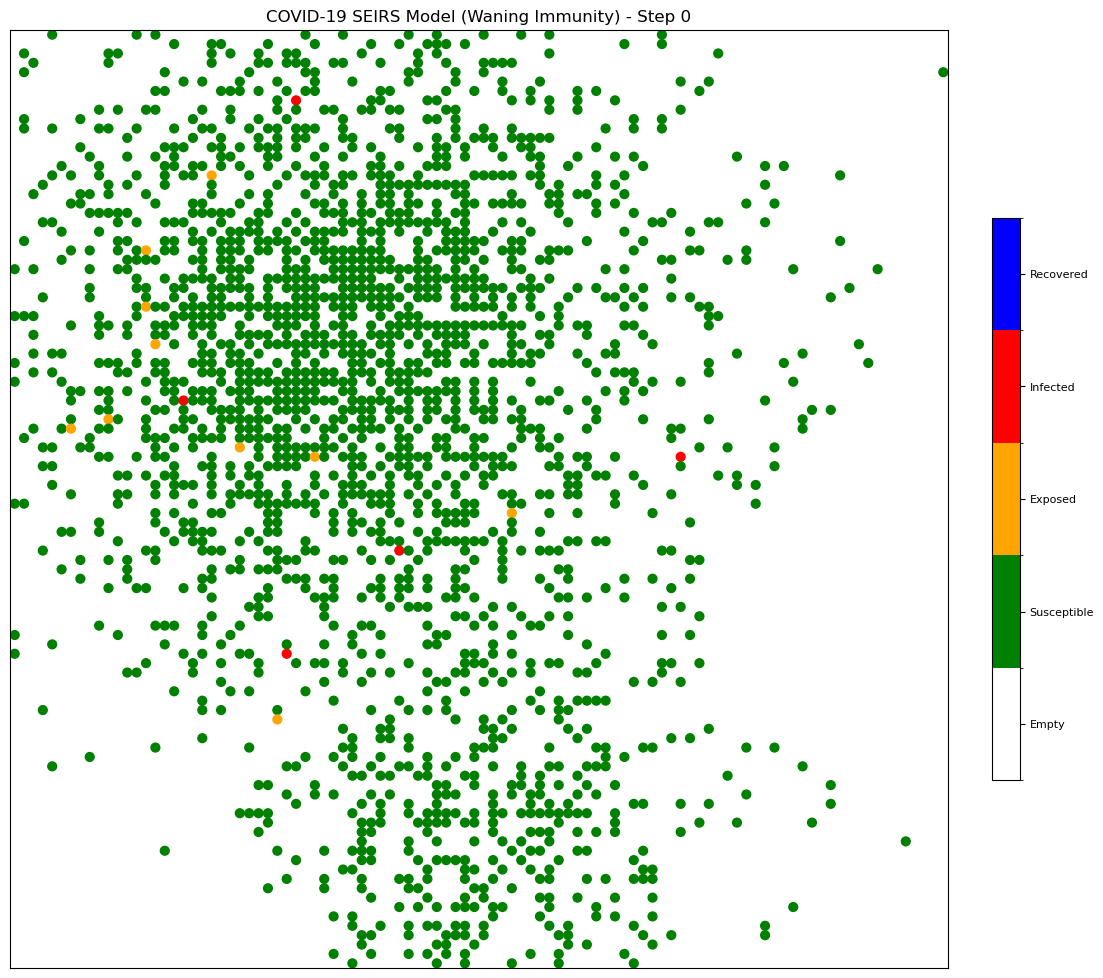

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation



# --- Simulation Parameters ---
GRID_SIZE = 100
N_STEPS = 300 # Increased steps to observe waning immunity effects

# --- Visual Parameters ---
MARKER_SIZE = 40
FIGURE_SIZE_INCHES = (12, 10)
COLORBAR_SHRINK_FACTOR = 0.6
COLORBAR_FRACTION = 0.03
COLORBAR_PAD = 0.04
COLORBAR_LABEL_FONTSIZE = 8

# --- COVID-19 Meta-Parameters (Modified for requested dynamics) ---

# 1. Increase Growth Rate and Replication Power
# Increased "Transmission Power"
INFECTION_PROBABILITY = 0.1  # Previously 0.08
# Shorter latency period (faster progression E -> I)
PROB_EXPOSED_BECOMES_INFECTED = 0.5 # Approx 0.33 (previously 1/5 = 0.2)

# 2. Increase Duration of Infection
# Longer infectious period (slower progression I -> R)
PROB_INFECTED_RECOVERS = 0.067   # Approx 0.067 (previously 1/10 = 0.1)

# 3. Waning Immunity (Recovered to Susceptible)
AVG_IMMUNITY_DURATION = 75 # Average number of steps immunity lasts
PROB_WANING_IMMUNITY = 1/AVG_IMMUNITY_DURATION # Daily probability of losing immunity

# Population & Initial Conditions
TARGET_POPULATION_RATIO = 0.65
MAX_TOTAL_POPULATION = int((GRID_SIZE**2) * TARGET_POPULATION_RATIO * 0.6)
INITIAL_INFECTED_COUNT = 5 # Reduced slightly due to higher infectivity
INITIAL_EXPOSED_COUNT = 10

N_POPULATION_CENTERS = 3
POPULATION_CENTER_STD_DEV_RANGE = (GRID_SIZE / 8, GRID_SIZE / 4)

# --- State Definitions ---
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# --- Color Mapping ---
colors_list = ['white', 'green', 'orange', 'red', 'blue']
cmap = mcolors.ListedColormap(colors_list)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
tick_labels = ['Empty', 'Susceptible', 'Exposed', 'Infected', 'Recovered']


# --- Helper Functions ---
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-(((x - x0)**2 / (2 * sigma_x**2)) + ((y - y0)**2 / (2 * sigma_y**2))))

def initialize_grid_non_uniform(size, n_centers, std_dev_range, target_pop_max,
                                n_initial_infected, n_initial_exposed):
    grid = np.full((size, size), EMPTY, dtype=int)
    density_map = np.zeros((size, size))
    for _ in range(n_centers):
        x0 = np.random.randint(int(size*0.1), int(size*0.9))
        y0 = np.random.randint(int(size*0.1), int(size*0.9))
        sigma = np.random.uniform(std_dev_range[0], std_dev_range[1])
        for r_idx in range(size):
            for c_idx in range(size):
                density_map[r_idx, c_idx] += gaussian_2d(r_idx, c_idx, x0, y0, sigma, sigma)
    if np.max(density_map) > 0:
        density_map /= np.max(density_map)
    populated_count = 0
    susceptible_coords = []
    all_coords = [(r_idx, c_idx) for r_idx in range(size) for c_idx in range(size)]
    np.random.shuffle(all_coords)
    for r_idx, c_idx in all_coords:
        if populated_count < target_pop_max:
            if np.random.rand() < density_map[r_idx,c_idx] * TARGET_POPULATION_RATIO * 1.2:
                grid[r_idx, c_idx] = SUSCEPTIBLE
                susceptible_coords.append((r_idx,c_idx))
                populated_count += 1
        else:
            break
    if not susceptible_coords:
        print("Warning: No susceptible individuals placed.")
    placed_exposed_infected_count = 0
    if susceptible_coords:
        num_to_pick = min(n_initial_exposed + n_initial_infected, len(susceptible_coords))
        indices_to_process = np.random.choice(len(susceptible_coords), size=num_to_pick, replace=False)
        for i, sc_idx_in_list in enumerate(indices_to_process):
            r_s, c_s = susceptible_coords[sc_idx_in_list]
            if i < n_initial_exposed:
                grid[r_s, c_s] = EXPOSED
                placed_exposed_infected_count +=1
            elif (i - n_initial_exposed) < n_initial_infected :
                grid[r_s, c_s] = INFECTED
                placed_exposed_infected_count +=1
    if placed_exposed_infected_count < (n_initial_exposed + n_initial_infected) and susceptible_coords:
         print(f"Warning: Could only place {placed_exposed_infected_count} of {n_initial_exposed + n_initial_infected} initial E/I individuals. (Susceptible count: {len(susceptible_coords)})")
    return grid

def count_infected_neighbors(grid, r, c):
    infected_neighbors = 0
    for i in range(max(0, r - 1), min(grid.shape[0], r + 2)):
        for j in range(max(0, c - 1), min(grid.shape[1], c + 2)):
            if (i, j) == (r, c): continue
            if grid[i, j] == INFECTED: infected_neighbors += 1
    return infected_neighbors

def update_grid(current_grid): # MODIFIED for SEIRS
    """Updates the grid for one time step based on SEIRS rules."""
    new_grid = current_grid.copy()
    rows, cols = current_grid.shape

    for r_idx in range(rows):
        for c_idx in range(cols):
            state = current_grid[r_idx, c_idx]

            if state == EMPTY:
                continue

            elif state == SUSCEPTIBLE:
                infected_neighbors = count_infected_neighbors(current_grid, r_idx, c_idx)
                if infected_neighbors > 0:
                    prob_gets_infected = 1 - (1 - INFECTION_PROBABILITY) ** infected_neighbors
                    if np.random.rand() < prob_gets_infected:
                        new_grid[r_idx, c_idx] = EXPOSED

            elif state == EXPOSED:
                if np.random.rand() < PROB_EXPOSED_BECOMES_INFECTED:
                    new_grid[r_idx, c_idx] = INFECTED

            elif state == INFECTED:
                if np.random.rand() < PROB_INFECTED_RECOVERS:
                    new_grid[r_idx, c_idx] = RECOVERED
            
            elif state == RECOVERED: # New rule for waning immunity
                if np.random.rand() < PROB_WANING_IMMUNITY:
                    new_grid[r_idx, c_idx] = SUSCEPTIBLE # Becomes susceptible again

    return new_grid

# --- Main Simulation and Animation --- 

grid_history = []
print("Initializing grid...")
current_grid = initialize_grid_non_uniform(
    GRID_SIZE, N_POPULATION_CENTERS, POPULATION_CENTER_STD_DEV_RANGE,
    MAX_TOTAL_POPULATION, INITIAL_INFECTED_COUNT, INITIAL_EXPOSED_COUNT
)
grid_history.append(current_grid.copy())
print("Grid initialized.")

print("Starting simulation (SEIRS model)...")
for step in range(N_STEPS):
    current_grid = update_grid(current_grid)
    grid_history.append(current_grid.copy())
    if (step + 1) % 10 == 0 or step == N_STEPS -1:
        print(f"Simulated step: {step+1}/{N_STEPS}")
print("Simulation finished.")

fig, ax = plt.subplots(figsize=FIGURE_SIZE_INCHES)

initial_particle_coords_xy_list = []
initial_particle_states_list = []
first_grid_frame = grid_history[0]
for r_idx in range(GRID_SIZE):
    for c_idx in range(GRID_SIZE):
        if first_grid_frame[r_idx, c_idx] != EMPTY:
            initial_particle_coords_xy_list.append([c_idx, r_idx])
            initial_particle_states_list.append(first_grid_frame[r_idx, c_idx])

if not initial_particle_coords_xy_list:
    initial_coords_np = np.empty((0, 2))
    initial_states_np = np.array([])
else:
    initial_coords_np = np.array(initial_particle_coords_xy_list)
    initial_states_np = np.array(initial_particle_states_list)

scatter = ax.scatter(
    initial_coords_np[:, 0] if initial_coords_np.shape[0] > 0 else [],
    initial_coords_np[:, 1] if initial_coords_np.shape[0] > 0 else [],
    s=MARKER_SIZE, 
    c=initial_states_np if initial_states_np.size > 0 else [],
    cmap=cmap, norm=norm, marker='o' 
)

ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(-0.5, GRID_SIZE - 0.5)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([-1, 0, 1, 2, 3])
cbar = plt.colorbar(mappable, boundaries=bounds, ticks=[-1, 0, 1, 2, 3], ax=ax,
                    shrink=COLORBAR_SHRINK_FACTOR, 
                    fraction=COLORBAR_FRACTION, 
                    pad=COLORBAR_PAD)
cbar.ax.set_yticklabels(tick_labels)
cbar.ax.tick_params(labelsize=COLORBAR_LABEL_FONTSIZE)

ax.set_title(f"COVID-19 SEIRS Model (Waning Immunity) - Step 0") # Updated title
ax.set_xticks([])
ax.set_yticks([])

def animate(step):
    current_display_grid = grid_history[step]
    particle_coords_list = []
    particle_states_list = []
    for r_idx in range(GRID_SIZE):
        for c_idx in range(GRID_SIZE):
            if current_display_grid[r_idx, c_idx] != EMPTY:
                particle_coords_list.append([c_idx, r_idx])
                particle_states_list.append(current_display_grid[r_idx, c_idx])
    if not particle_coords_list:
        scatter.set_offsets(np.empty((0,2)))
    else:
        offsets_np = np.array(particle_coords_list)
        states_np = np.array(particle_states_list)
        scatter.set_offsets(offsets_np)
        scatter.set_array(states_np)
    ax.set_title(f"COVID-19 SEIRS Model (Waning Immunity) - Step {step}") # Updated title
    return [scatter]

print("Creating animation object...")
ani = FuncAnimation(fig, animate, frames=N_STEPS + 1, interval=200, blit=False, repeat=False)
print("Animation object created.")

plt.tight_layout(pad=1.5)

gif_filename = 'covid_simulation_seirs_waning_immunity.gif' # New filename
print(f"Saving animation to {gif_filename} ... (This may take a while)")
try:
    ani.save(gif_filename, writer='pillow', fps=10)
    print(f"Animation successfully saved to {gif_filename}")
except Exception as e:
    print(f"Error saving GIF: {e}")
    print("Make sure you have a GIF writer installed, like Pillow (pip install Pillow).")

# --- Final Counts ---
final_grid = grid_history[-1]
empty_count = np.sum(final_grid == EMPTY)
susceptible_count = np.sum(final_grid == SUSCEPTIBLE)
exposed_count = np.sum(final_grid == EXPOSED)
infected_count = np.sum(final_grid == INFECTED)
recovered_count = np.sum(final_grid == RECOVERED)
total_populated = (GRID_SIZE*GRID_SIZE - empty_count)
if total_populated == 0:
    print("Warning: Total populated count is zero. Percentages will be zero.")
    total_populated = 1

print(f"\n--- Simulation Complete ({N_STEPS} steps) ---")
print(f"Model: SEIRS (with waning immunity)")
print(f"Avg. Immunity Duration: {AVG_IMMUNITY_DURATION} steps")
print(f"Infection Probability per contact: {INFECTION_PROBABILITY}")
print(f"Avg. Latency Period: {1/PROB_EXPOSED_BECOMES_INFECTED:.1f} steps")
print(f"Avg. Infectious Period: {1/PROB_INFECTED_RECOVERS:.1f} steps")
print(f"Final Susceptible: {susceptible_count} ({(susceptible_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Exposed: {exposed_count} ({(exposed_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Infected: {infected_count} ({(infected_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Recovered: {recovered_count} ({(recovered_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Total Populated Cells at end: {GRID_SIZE*GRID_SIZE - empty_count}")

Initializing grid...
Grid initialized.
Starting simulation (SEIRS model with user-defined aggressive parameters)...
Simulated step: 10/300
Simulated step: 20/300
Simulated step: 30/300
Simulated step: 40/300
Simulated step: 50/300
Simulated step: 60/300
Simulated step: 70/300
Simulated step: 80/300
Simulated step: 90/300
Simulated step: 100/300
Simulated step: 110/300
Simulated step: 120/300
Simulated step: 130/300
Simulated step: 140/300
Simulated step: 150/300
Simulated step: 160/300
Simulated step: 170/300
Simulated step: 180/300
Simulated step: 190/300
Simulated step: 200/300
Simulated step: 210/300
Simulated step: 220/300
Simulated step: 230/300
Simulated step: 240/300
Simulated step: 250/300
Simulated step: 260/300
Simulated step: 270/300
Simulated step: 280/300
Simulated step: 290/300
Simulated step: 300/300
Simulation finished.
Creating animation object...
Animation object created.
Saving animation to covid_simulation_seirs_aggressive.gif ... (This may take a while)
Animation s

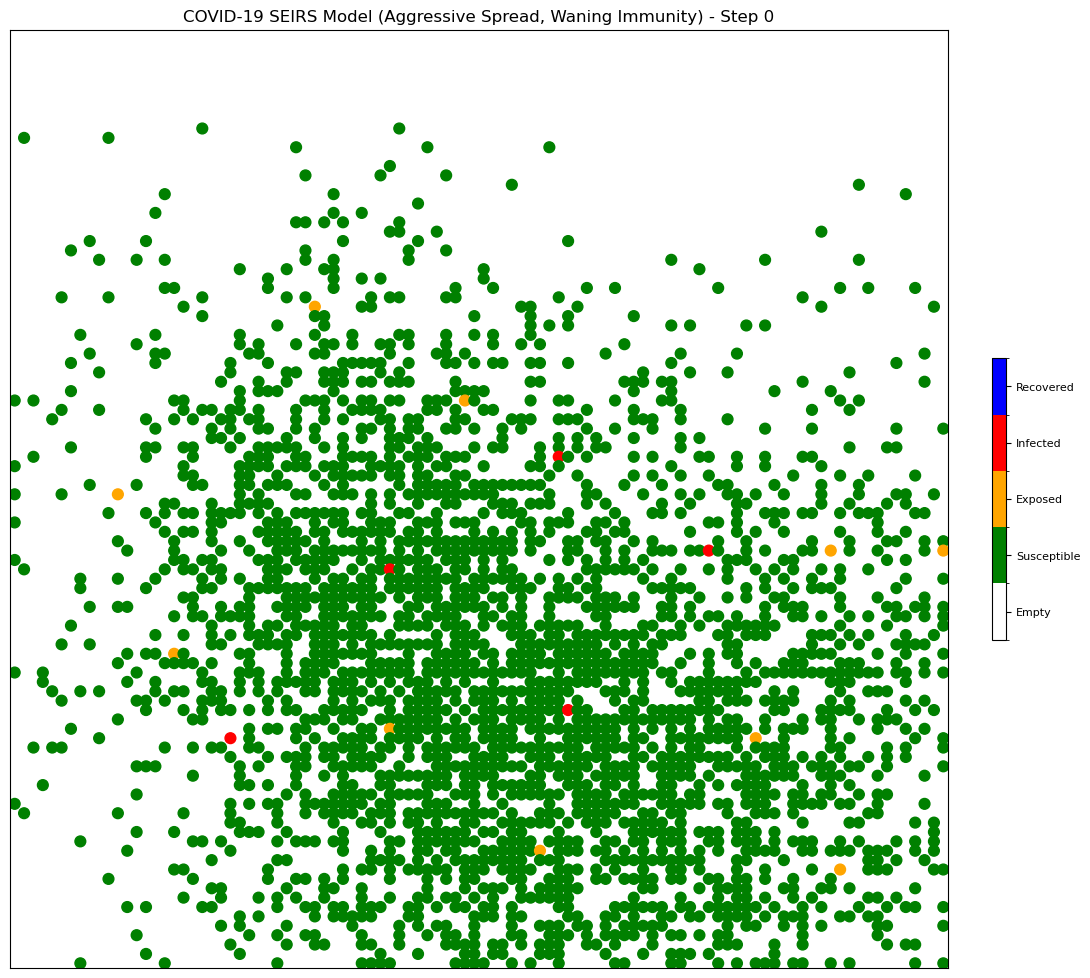

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
# Pillow is often used as a writer for GIFs with Matplotlib.
# If not installed, run: pip install Pillow

# --- Simulation Parameters ---
GRID_SIZE = 100 # User's setting
N_STEPS = 300   # Increased steps to observe waning immunity effects

# --- Visual Parameters ---
MARKER_SIZE = 60
FIGURE_SIZE_INCHES = (12, 10)
COLORBAR_SHRINK_FACTOR = 0.3
COLORBAR_FRACTION = 0.03
COLORBAR_PAD = 0.04
COLORBAR_LABEL_FONTSIZE = 8

# --- COVID-19 Meta-Parameters (User-defined for aggressive spread) ---
# 1. Increase Growth Rate and Replication Power
INFECTION_PROBABILITY = 0.1  # "Transmission Power"
PROB_EXPOSED_BECOMES_INFECTED = 0.5 # Avg Latency: 1/0.5 = 2 days

# 2. Increase Duration of Infection
PROB_INFECTED_RECOVERS = 0.067    # Avg Infectious Period: 1/0.067 approx 14.9 days

# 3. Waning Immunity (Recovered to Susceptible)
AVG_IMMUNITY_DURATION = 75 # Average number of steps immunity lasts
PROB_WANING_IMMUNITY = 1/AVG_IMMUNITY_DURATION # Daily probability of losing immunity

# Population & Initial Conditions
TARGET_POPULATION_RATIO = 0.65
MAX_TOTAL_POPULATION = int((GRID_SIZE**2) * TARGET_POPULATION_RATIO * 0.6)
INITIAL_INFECTED_COUNT = 5 # Reduced slightly due to higher infectivity
INITIAL_EXPOSED_COUNT = 10

N_POPULATION_CENTERS = 3
POPULATION_CENTER_STD_DEV_RANGE = (GRID_SIZE / 8, GRID_SIZE / 4)

# --- State Definitions ---
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# --- Color Mapping ---
colors_list = ['white', 'green', 'orange', 'red', 'blue']
cmap = mcolors.ListedColormap(colors_list)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
tick_labels = ['Empty', 'Susceptible', 'Exposed', 'Infected', 'Recovered']


# --- Helper Functions ---
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-(((x - x0)**2 / (2 * sigma_x**2)) + ((y - y0)**2 / (2 * sigma_y**2))))

def initialize_grid_non_uniform(size, n_centers, std_dev_range, target_pop_max,
                                n_initial_infected, n_initial_exposed):
    grid = np.full((size, size), EMPTY, dtype=int)
    density_map = np.zeros((size, size))
    for _ in range(n_centers):
        x0 = np.random.randint(int(size*0.1), int(size*0.9))
        y0 = np.random.randint(int(size*0.1), int(size*0.9))
        sigma = np.random.uniform(std_dev_range[0], std_dev_range[1])
        for r_idx in range(size):
            for c_idx in range(size):
                density_map[r_idx, c_idx] += gaussian_2d(r_idx, c_idx, x0, y0, sigma, sigma)
    if np.max(density_map) > 0:
        density_map /= np.max(density_map)
    populated_count = 0
    susceptible_coords = []
    all_coords = [(r_idx, c_idx) for r_idx in range(size) for c_idx in range(size)]
    np.random.shuffle(all_coords)
    for r_idx, c_idx in all_coords:
        if populated_count < target_pop_max:
            if np.random.rand() < density_map[r_idx,c_idx] * TARGET_POPULATION_RATIO * 1.2:
                grid[r_idx, c_idx] = SUSCEPTIBLE
                susceptible_coords.append((r_idx,c_idx))
                populated_count += 1
        else:
            break
    if not susceptible_coords:
        print("Warning: No susceptible individuals placed.")
    placed_exposed_infected_count = 0
    if susceptible_coords:
        num_to_pick = min(n_initial_exposed + n_initial_infected, len(susceptible_coords))
        indices_to_process = np.random.choice(len(susceptible_coords), size=num_to_pick, replace=False)
        for i, sc_idx_in_list in enumerate(indices_to_process):
            r_s, c_s = susceptible_coords[sc_idx_in_list]
            if i < n_initial_exposed:
                grid[r_s, c_s] = EXPOSED
                placed_exposed_infected_count +=1
            elif (i - n_initial_exposed) < n_initial_infected :
                grid[r_s, c_s] = INFECTED
                placed_exposed_infected_count +=1
    if placed_exposed_infected_count < (n_initial_exposed + n_initial_infected) and susceptible_coords:
         print(f"Warning: Could only place {placed_exposed_infected_count} of {n_initial_exposed + n_initial_infected} initial E/I individuals. (Susceptible count: {len(susceptible_coords)})")
    return grid

def count_infected_neighbors(grid, r, c):
    infected_neighbors = 0
    for i in range(max(0, r - 1), min(grid.shape[0], r + 2)):
        for j in range(max(0, c - 1), min(grid.shape[1], c + 2)):
            if (i, j) == (r, c): continue
            if grid[i, j] == INFECTED: infected_neighbors += 1
    return infected_neighbors

def update_grid(current_grid): # SEIRS model
    """Updates the grid for one time step based on SEIRS rules."""
    new_grid = current_grid.copy()
    rows, cols = current_grid.shape

    for r_idx in range(rows):
        for c_idx in range(cols):
            state = current_grid[r_idx, c_idx]

            if state == EMPTY:
                continue

            elif state == SUSCEPTIBLE:
                infected_neighbors = count_infected_neighbors(current_grid, r_idx, c_idx)
                if infected_neighbors > 0:
                    prob_gets_infected = 1 - (1 - INFECTION_PROBABILITY) ** infected_neighbors
                    if np.random.rand() < prob_gets_infected:
                        new_grid[r_idx, c_idx] = EXPOSED

            elif state == EXPOSED:
                if np.random.rand() < PROB_EXPOSED_BECOMES_INFECTED:
                    new_grid[r_idx, c_idx] = INFECTED

            elif state == INFECTED:
                if np.random.rand() < PROB_INFECTED_RECOVERS:
                    new_grid[r_idx, c_idx] = RECOVERED
            
            elif state == RECOVERED: # Waning immunity rule
                if np.random.rand() < PROB_WANING_IMMUNITY:
                    new_grid[r_idx, c_idx] = SUSCEPTIBLE # Becomes susceptible again

    return new_grid

# --- Main Simulation and Animation ---
grid_history = []
print("Initializing grid...")
current_grid = initialize_grid_non_uniform(
    GRID_SIZE, N_POPULATION_CENTERS, POPULATION_CENTER_STD_DEV_RANGE,
    MAX_TOTAL_POPULATION, INITIAL_INFECTED_COUNT, INITIAL_EXPOSED_COUNT
)
grid_history.append(current_grid.copy())
print("Grid initialized.")

print("Starting simulation (SEIRS model with user-defined aggressive parameters)...")
for step in range(N_STEPS):
    current_grid = update_grid(current_grid)
    grid_history.append(current_grid.copy())
    if (step + 1) % 10 == 0 or step == N_STEPS -1:
        print(f"Simulated step: {step+1}/{N_STEPS}")
print("Simulation finished.")

fig, ax = plt.subplots(figsize=FIGURE_SIZE_INCHES)

initial_particle_coords_xy_list = []
initial_particle_states_list = []
first_grid_frame = grid_history[0]
for r_idx in range(GRID_SIZE):
    for c_idx in range(GRID_SIZE):
        if first_grid_frame[r_idx, c_idx] != EMPTY:
            initial_particle_coords_xy_list.append([c_idx, r_idx])
            initial_particle_states_list.append(first_grid_frame[r_idx, c_idx])

if not initial_particle_coords_xy_list:
    initial_coords_np = np.empty((0, 2))
    initial_states_np = np.array([])
else:
    initial_coords_np = np.array(initial_particle_coords_xy_list)
    initial_states_np = np.array(initial_particle_states_list)

scatter = ax.scatter(
    initial_coords_np[:, 0] if initial_coords_np.shape[0] > 0 else [],
    initial_coords_np[:, 1] if initial_coords_np.shape[0] > 0 else [],
    s=MARKER_SIZE, 
    c=initial_states_np if initial_states_np.size > 0 else [],
    cmap=cmap, norm=norm, marker='o' 
)

ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(-0.5, GRID_SIZE - 0.5)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([-1, 0, 1, 2, 3])
cbar = plt.colorbar(mappable, boundaries=bounds, ticks=[-1, 0, 1, 2, 3], ax=ax,
                    shrink=COLORBAR_SHRINK_FACTOR, 
                    fraction=COLORBAR_FRACTION, 
                    pad=COLORBAR_PAD)
cbar.ax.set_yticklabels(tick_labels)
cbar.ax.tick_params(labelsize=COLORBAR_LABEL_FONTSIZE)

ax.set_title(f"COVID-19 SEIRS Model (Aggressive Spread, Waning Immunity) - Step 0")
ax.set_xticks([])
ax.set_yticks([])

def animate(step):
    current_display_grid = grid_history[step]
    particle_coords_list = []
    particle_states_list = []
    for r_idx in range(GRID_SIZE):
        for c_idx in range(GRID_SIZE):
            if current_display_grid[r_idx, c_idx] != EMPTY:
                particle_coords_list.append([c_idx, r_idx])
                particle_states_list.append(current_display_grid[r_idx, c_idx])
    if not particle_coords_list:
        scatter.set_offsets(np.empty((0,2)))
        # scatter.set_array(np.array([])) # Optional: explicitly clear color array
    else:
        offsets_np = np.array(particle_coords_list)
        states_np = np.array(particle_states_list)
        scatter.set_offsets(offsets_np)
        scatter.set_array(states_np)
    ax.set_title(f"COVID-19 SEIRS Model (Aggressive Spread, Waning Immunity) - Step {step}")
    return [scatter]

print("Creating animation object...")
ani = FuncAnimation(fig, animate, frames=N_STEPS + 1, interval=200, blit=False, repeat=False)
print("Animation object created.")

# Apply tight_layout after all plot elements are added and before saving
plt.tight_layout(pad=1.5) 

gif_filename = 'covid_simulation_seirs_aggressive.gif' # Updated filename
print(f"Saving animation to {gif_filename} ... (This may take a while)")
try:
    ani.save(gif_filename, writer='pillow', fps=10)
    print(f"Animation successfully saved to {gif_filename}")
except Exception as e:
    print(f"Error saving GIF: {e}")
    print("Make sure you have a GIF writer installed, like Pillow (pip install Pillow).")

# --- Final Counts ---
final_grid = grid_history[-1]
empty_count = np.sum(final_grid == EMPTY)
susceptible_count = np.sum(final_grid == SUSCEPTIBLE)
exposed_count = np.sum(final_grid == EXPOSED)
infected_count = np.sum(final_grid == INFECTED)
recovered_count = np.sum(final_grid == RECOVERED)
total_populated = (GRID_SIZE*GRID_SIZE - empty_count)
if total_populated == 0:
    print("Warning: Total populated count is zero. Percentages will be zero.")
    total_populated = 1 # To prevent division by zero in prints

print(f"\n--- Simulation Complete ({N_STEPS} steps) ---")
print(f"Model: SEIRS (Aggressive Spread, Waning Immunity)")
print(f"Avg. Immunity Duration: {AVG_IMMUNITY_DURATION} steps")
print(f"Infection Probability per contact: {INFECTION_PROBABILITY}")
print(f"Avg. Latency Period: {1/PROB_EXPOSED_BECOMES_INFECTED:.1f} steps")
print(f"Avg. Infectious Period: {1/PROB_INFECTED_RECOVERS:.1f} steps")
print(f"Final Susceptible: {susceptible_count} ({(susceptible_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Exposed: {exposed_count} ({(exposed_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Infected: {infected_count} ({(infected_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Final Recovered: {recovered_count} ({(recovered_count/total_populated*100) if total_populated > 0 else 0:.2f}% of populated)")
print(f"Total Populated Cells at end: {GRID_SIZE*GRID_SIZE - empty_count}")